-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation

This Notebook teaches the user to use the `main.evolve()` function.  Given a model of decaying or annihilating DM, `main.evolve()` will compute the free electron fraction as a function of redshift, $x_e(z) = n_e(z)/n_{HI}(z)$, and the baryon temperature as a function of redshift, $T_m(z)$.

# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

# np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs provides $x_e$ and $T_m$ as functions of z, which are loaded below.

In [3]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of $x_e(z)$ and the histories of the DM decay/annihilation products.  Below we will either generate the $f_c$'s by using the standard history values ("without back-reaction"), or by including the effects of DM energy injection ("with back-reaction").

## Photon Transfer Functions

Transfer functions encode how particles (photons and electrons in our case) transfer energy as they evolve along with the universe.  For example, a high energy photon will lose energy through redshifting and scattering off of free electrons (what else am I missing???).  

Let $E_{in}^i$ be the energy of a single photon injected at redshift $z_{in}$. The photon produces $N^j$ photons at energies $E_{out}^j$ because of energy transfer processes that took place over $d(\ln(1+z))$ worth of cosmological time.  If we define $T^{ij} \equiv T(E_{in}^i, E_{out}^j)$, we have

$$ N_\gamma\left(E^j, (1+z_{in})e^{- d(\ln(1+z))} \right) = T^{ij} N_\gamma\left(E^i, 1+z_{in} \right), $$

where $N_\gamma(E, 1+z)$ represents the number of photons of energy E at redshift 1+z.  The transfer function allows us to evolve photon spectra $d(\ln(1+z))$ amount of time at a time.  We will set $d(\ln(1+z))$ = $0.002$ in our transfer functions, which has been shown to be small enough to converge.

We now load the transfer functions.

In [34]:
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp = main.load_trans_funcs()

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons.

Generating TransferFuncInterp objects for each tflist...
Done.



The above transfer functions end in `_interp` because only a finite number of them have been generated ($11 \times 494$ to be exact.  11 choices of ionization level, $x_e$, and 494 choices of input energy, $E_{in}$), which means we have to perform a 2D interpolation over different $x_e$ and $E_{in}$.

We now turn to the main function in DarkHistory: main.evolve().  It

In [59]:
%autoreload
end_rs   = 10
mDM = 1e8
sigmav = 1e-26
tau = 1e24


phot_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([mDM]), 
                                      highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

#!!! What about Reionization
a = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True
)

b = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=False
)

start to evolve
rs, fs:  2994.005996001995   [5.010253871064946e-06, 3.139708532323484e-05, 0.0002113287238244386, 2.6324947675953802e-18, 0.002632474604939014]
rs, fs:  2988.023968031968   [2.0911031212181267e-05, 0.00011400683398819265, 0.0006591080663632204, 8.31465202515223e-18, 0.008314585865768418]
rs, fs:  2982.053892161797   [4.3113566113991716e-05, 0.00021772541128304762, 0.0011326374444918987, 1.4426114020448714e-17, 0.014425994774152791]


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:662: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


rs, fs:  2976.095744511174   [6.995630529748119e-05, 0.00033668626888452456, 0.0016229273624116104, 2.0844959714827655e-17, 0.02084478078346178]
rs, fs:  2970.149501247497   [0.00010017927491325333, 0.0004664165507982195, 0.002123144617948969, 2.7496366674205697e-17, 0.027496121629245987]
rs, fs:  2964.215138585785   [0.0001328065141706632, 0.0006034624394151668, 0.002628045542201953, 3.4330210546906635e-17, 0.03432989295674459]
rs, fs:  2958.29263278858   [0.00016707148202139377, 0.0007451358774270877, 0.0031335852289433603, 4.130976494437962e-17, 0.041309368279188616]
rs, fs:  2952.38196016585   [0.00020236693922506726, 0.0008893355428200465, 0.003636637536537389, 4.8405958937941095e-17, 0.04840547651436769]
rs, fs:  2946.4830970748976   [0.00023820952454311087, 0.001034415775005108, 0.004134788447687652, 5.559442498085523e-17, 0.05559384992756716]
rs, fs:  2940.5960199202623   [0.00027421367345049777, 0.0011790880684000205, 0.004626180238446626, 6.285395274872058e-17, 0.062853277982

rs, fs:  2634.2862927617125   [0.0008655321468763349, 0.003907629698872544, 0.017211394875537342, 3.5887207273782576e-16, 0.3588394445114209]
rs, fs:  2629.022985238149   [0.0008559783246636571, 0.003886416972450541, 0.017256522000537084, 3.6164339206642915e-16, 0.36160913462261285]
rs, fs:  2623.7701938100317   [0.0008460016764499532, 0.0038637855928555283, 0.017297876211023695, 3.6433894088483867e-16, 0.3643029789635496]
rs, fs:  2618.5278974661883   [0.0008417047599244755, 0.0038570618343263573, 0.017359816206822195, 3.6704313621916754e-16, 0.36700538292006124]
rs, fs:  2613.2960752374256   [0.0008411156883121804, 0.00386177320301954, 0.017437234881332943, 3.6970588315122223e-16, 0.36966625262529873]
rs, fs:  2608.0747061964485   [0.0008409879668819843, 0.003867963713941124, 0.01751539622496457, 3.723000207220503e-16, 0.3722584260156649]
rs, fs:  2602.8637694577737   [0.000840720988362228, 0.0038736543562364625, 0.017591269533292167, 3.7482478212253624e-16, 0.3747811320088555]
rs, f

rs, fs:  2322.4259063768027   [0.0006270763552494612, 0.0034429328720083927, 0.0190629370814232, 4.416344154716211e-16, 0.4409991516650903]
rs, fs:  2317.785696320842   [0.0006211312748877677, 0.0034270012123826543, 0.019057163634033265, 4.419504877994529e-16, 0.44128430342098995]
rs, fs:  2313.154757410757   [0.0006151452533139426, 0.0034109158833380408, 0.019050772361568883, 4.422498863721552e-16, 0.4415512350237134]
rs, fs:  2308.533071122786   [0.0006091194665160891, 0.0033946815196510775, 0.01904377931791335, 4.42533108415298e-16, 0.4418003585131587]
rs, fs:  2303.9206189701777   [0.0006030550621214088, 0.003378302649132629, 0.019036200175338688, 4.4280062129056057e-16, 0.4420320756310007]
rs, fs:  2299.3173825031167   [0.0005969531603018589, 0.0033617836959956644, 0.019028050234941012, 4.4305293173581396e-16, 0.4422467780481606]
rs, fs:  2294.7233433086517   [0.0005927280195315805, 0.0033502558630876156, 0.019027237226271292, 4.4335927500335453e-16, 0.44251349560056935]
rs, fs:  

rs, fs:  2051.5842276371463   [0.00048802796913526117, 0.0030653608306648182, 0.01914834226262112, 4.567656500518133e-16, 0.44255494674924933]
rs, fs:  2047.4851596162493   [0.0004858969740124829, 0.003058928950059805, 0.01914297643008369, 4.573049660784373e-16, 0.44231895772604246]
rs, fs:  2043.3942815387206   [0.0004837602419989474, 0.0030524675650654455, 0.01913743987212251, 4.578826781805465e-16, 0.4420771935921419]
rs, fs:  2039.3115770410427   [0.0004816179672943077, 0.0030459775833615857, 0.01913173635920515, 4.585015324737004e-16, 0.4418297442478351]
rs, fs:  2035.2370297923921   [0.00047947034173511407, 0.0030394598997217715, 0.019125869586403783, 4.591644442162984e-16, 0.44157669745428474]
rs, fs:  2031.1706234945743   [0.0004773175548821312, 0.0030329153964207527, 0.019119843175236968, 4.5987450881610565e-16, 0.4413181388769377]
rs, fs:  2027.1123418819586   [0.00047515979410770517, 0.0030263449436401992, 0.019113660675482695, 4.60635014991478e-16, 0.44105415212821747]
rs, 

rs, fs:  1815.9564319387669   [0.0004299741914460407, 0.0028784271412469523, 0.019049017380756934, 1.017429177751792e-15, 0.42703863036267964]
rs, fs:  1812.3281485676885   [0.00042918534273790853, 0.0028755484471232155, 0.019045003603067285, 1.0668270099439264e-15, 0.4266859678986856]
rs, fs:  1808.7071145116208   [0.0004283942918576637, 0.0028726543406230225, 0.01904089283949376, 1.121487101644353e-15, 0.426330088004641]
rs, fs:  1805.0933152864227   [0.0004276019370644703, 0.0028697510032293467, 0.01903672843344065, 1.1821229945261658e-15, 0.4259708755776467]
rs, fs:  1801.4867364368927   [0.00042680854524225454, 0.002866840113732853, 0.019032521255517135, 1.24961802289456e-15, 0.42560920206643527]
rs, fs:  1797.8873635367104   [0.0004260133905765254, 0.0028639164791323165, 0.019028233485133206, 1.324851890333699e-15, 0.42524470857972774]
rs, fs:  1794.2951821883794   [0.0004252163773361949, 0.0028609793234128703, 0.01902385891520566, 1.4090449255485546e-15, 0.4248772737226846]
rs, 

rs, fs:  1600.974151509077   [0.0004025821247761892, 0.0027721658714444744, 0.018925403738332253, 2.2123790704028887e-08, 0.4063481185199601]
rs, fs:  1597.7754030207968   [0.0004022270837444723, 0.0027706015404565625, 0.01892244250415567, 4.55845776433985e-08, 0.40597902961669474]
rs, fs:  1594.5830456362592   [0.00040187376682506934, 0.002769034248245785, 0.018919437682784066, 9.623925416740146e-08, 0.4056080593732265]
rs, fs:  1591.3970665860302   [0.00040152545080238724, 0.0027674709478320344, 0.018916396424691246, 2.083246821138229e-07, 0.40523519170931893]
rs, fs:  1588.2174531261894   [0.00040118921574133645, 0.0027659268083548415, 0.018913332596108685, 4.6266581637960747e-07, 0.40486033127514204]
rs, fs:  1585.0441925382788   [0.00040088079090552, 0.002764436289623036, 0.01891027729426823, 1.0549264750292697e-06, 0.40448322848752544]
rs, fs:  1581.8772721292517   [0.0004006360241687232, 0.0027630798380476047, 0.018907302818451262, 2.472039955892082e-06, 0.4041032357637975]
rs, 

rs, fs:  1411.442581286904   [0.0005695238424325395, 0.0031500462745312017, 0.019781404997929696, 0.00018194907530095657, 0.3845043835559936]
rs, fs:  1408.6225171285103   [0.0005730347928300781, 0.0031582281763115967, 0.019798005727803752, 0.00018216670115668915, 0.38417310454626463]
rs, fs:  1405.8080874620632   [0.0005767321937853103, 0.0031668600414616736, 0.01981542940368141, 0.00018239599605142042, 0.38384098049164933]
rs, fs:  1402.9992810298402   [0.000580627434767391, 0.003175969176414602, 0.019833726122796977, 0.00018263734859329242, 0.3835080026563421]
rs, fs:  1400.1960865966123   [0.0005847361995609261, 0.00318559319512422, 0.019852962648464978, 0.00018289152055820374, 0.38317413388768384]
rs, fs:  1397.3984929495975   [0.0005890694179629066, 0.003195758741475681, 0.01987318819522973, 0.000183158522412264, 0.38283935975451466]
rs, fs:  1394.6064888984176   [0.0005936419636283934, 0.0032065015823015473, 0.019894465081595793, 0.0001834389027655108, 0.3825037257238646]
rs, fs

rs, fs:  1244.3487350448604   [0.001725848272679944, 0.0056784408347581835, 0.023356607914539536, 0.0009263628078079454, 0.36718414288315826]
rs, fs:  1241.8625246139386   [0.001781307950542436, 0.0057931756026889675, 0.023501561168300496, 0.0009525534196557965, 0.366929466350901]
rs, fs:  1239.381281634771   [0.0018407136236757496, 0.005915581377890954, 0.023654656047669285, 0.0009811126330153547, 0.36666363844722094]
rs, fs:  1236.9049961823825   [0.0019043512616886567, 0.0060461671422962476, 0.023816348851464903, 0.001012299993113422, 0.3663850742905336]
rs, fs:  1234.433658351628   [0.0019344216369997468, 0.0061251164968731285, 0.023938171033089404, 0.0010230971793128555, 0.3662634385945912]
rs, fs:  1231.967258257153   [0.0019653811899330302, 0.006207134626242948, 0.02406476909870161, 0.001033991163825189, 0.36614424323353933]
rs, fs:  1229.5057860333534   [0.0019981344102655034, 0.006293474101366417, 0.02419245930430053, 0.0010456073545877125, 0.36606099370738876]
rs, fs:  1227.0

rs, fs:  1103.6383235144447   [0.008270945210995351, 0.021017987197342297, 0.045169476808977614, 0.002147178476207933, 0.33366722075044364]
rs, fs:  1101.4332526732808   [0.00844875869580677, 0.021479510204796434, 0.04579952006845616, 0.0021763047847068394, 0.3324772641299769]
rs, fs:  1099.232587566596   [0.008629603169534313, 0.021950718139043257, 0.04644378827414465, 0.002205414808070168, 0.33121620604611474]
rs, fs:  1097.0363193917274   [0.008813696958168289, 0.022432194719231826, 0.04710311559903706, 0.0022345585537560135, 0.329891899462378]
rs, fs:  1094.844439363599   [0.009001061991742146, 0.022924033131797195, 0.047777670777984504, 0.0022637448024630837, 0.3285105944929825]
rs, fs:  1092.6569387146876   [0.009191891655976987, 0.0234267892761822, 0.04846826205335256, 0.0022930037961906946, 0.3270754898299091]
rs, fs:  1090.4738086949883   [0.009386270575727284, 0.023940752757162356, 0.049175344871731516, 0.0023223418996234316, 0.3255888035877963]
rs, fs:  1088.2950405719776   

rs, fs:  971.0399082977275   [0.023977862146149467, 0.05800308300889039, 0.09126972563956699, 0.0051096743877694474, 0.22124796384337192]
rs, fs:  969.099769266876   [0.024213835673211018, 0.05853483788486513, 0.09189407310969985, 0.0051618810739103545, 0.21943924681453827]
rs, fs:  967.1635066363938   [0.024449486487810843, 0.05906546577033869, 0.09251645936794758, 0.0052141238736524, 0.2176251915177785]
rs, fs:  965.2311126612277   [0.0246847887744718, 0.059594906316392415, 0.09313682786400447, 0.0052664006165018505, 0.21580653430775182]
rs, fs:  963.3025796117992   [0.02491971227008402, 0.060123089080824844, 0.09375510961215183, 0.005318708094057288, 0.21398396578354034]
rs, fs:  961.3778997739736   [0.025154221978694036, 0.06064993289578903, 0.09437122239699484, 0.005371041994219509, 0.21215813470792255]
rs, fs:  959.4570654490288   [0.02538827957252215, 0.061175349121480795, 0.09498507510003563, 0.005423397216895319, 0.2103296555474007]
rs, fs:  957.5400689536251   [0.025621843666

rs, fs:  852.6657067177675   [0.03431370203700712, 0.08047469843954758, 0.11737527089307559, 0.006011728846923324, 0.1324022812130415]
rs, fs:  850.9620794994263   [0.03438122663189165, 0.08064353923615668, 0.11756848471959204, 0.006008613900368848, 0.13147341199002666]
rs, fs:  849.2618561305376   [0.03444689493144271, 0.08080801482823666, 0.11775606751189577, 0.006005278076826943, 0.13055369204219003]
rs, fs:  847.5650298102057   [0.034510969883888847, 0.08096875737965904, 0.11793880106247263, 0.006001739416290929, 0.12964155933393728]
rs, fs:  845.8715937511232   [0.03457349440314799, 0.08112586704623972, 0.11811681101916749, 0.0059980031120510004, 0.1287367967910143]
rs, fs:  844.1815411795436   [0.03463427500738486, 0.08127886966408018, 0.11828951851329231, 0.005994063643531255, 0.12784074554635647]
rs, fs:  842.4948653352542   [0.0346933798834015, 0.0814279258214276, 0.11845712496807516, 0.00598992855990754, 0.1269530642028697]
rs, fs:  840.8115594715496   [0.03475095295945793, 0

rs, fs:  753.2276963265301   [0.03634890121232375, 0.08455896973330747, 0.11828315796471568, 0.005758404439465551, 0.09399204893359678]
rs, fs:  751.7227463854682   [0.036370679785052346, 0.08457445224600531, 0.11813508114957813, 0.0057661960286315254, 0.09359927949483868]
rs, fs:  750.2208033363942   [0.03639133676557577, 0.08458763050094345, 0.11798592004870745, 0.005773834759522209, 0.0932097649709192]
rs, fs:  748.7218611715338   [0.03641084598086243, 0.0845984611135714, 0.11783568263656927, 0.00578131258443862, 0.09282357765335451]
rs, fs:  747.2259138951164   [0.036429256766155396, 0.08460704076180475, 0.11768439614856616, 0.0057886382743763155, 0.09244054448412252]
rs, fs:  745.7329555233508   [0.03644654674459946, 0.08461333289327014, 0.11753206856001294, 0.0057958046402085805, 0.0920607250394048]
rs, fs:  744.2429800844017   [0.03646275321849012, 0.08461741154337611, 0.11737872317224371, 0.005802817899699704, 0.09168398675834616]
rs, fs:  742.7559816183652   [0.036477873518185

rs, fs:  652.2106337480122   [0.03453030617238449, 0.08032911649575969, 0.11010519543986874, 0.004852379155866343, 0.0737819908257453]
rs, fs:  650.9075160326043   [0.03448879793814229, 0.08023395462174597, 0.10997014127892331, 0.004841344607951617, 0.07358587322788093]
rs, fs:  649.6070019481284   [0.034446978803355024, 0.08013806857214406, 0.10983426703770258, 0.0048303261620826505, 0.07339042190310935]
rs, fs:  648.3090862925264   [0.034404873104586696, 0.08004151490145527, 0.10969762349020731, 0.0048193197294262415, 0.07319551207817417]
rs, fs:  647.013763874134   [0.034362482371081866, 0.07994429723524006, 0.1095602147045264, 0.004808324979006258, 0.07300113648944191]
rs, fs:  645.7210295116598   [0.0343197798006324, 0.07984635346345728, 0.10942198723930788, 0.004797346322954476, 0.07280743565068849]
rs, fs:  644.4308780341645   [0.03427679479422086, 0.07974775187439098, 0.1092830020496506, 0.004786378873361195, 0.07261425884180438]
rs, fs:  643.1433042810407   [0.0342335301257126

rs, fs:  572.7031774919415   [0.03169418676604735, 0.07383019597122717, 0.1010067335456348, 0.0042856363163422135, 0.0626427107852187]
rs, fs:  571.55891578009   [0.0316492169909599, 0.07372721552079305, 0.10086392062120846, 0.004278798943748781, 0.062491956331652755]
rs, fs:  570.4169403046639   [0.031604046317587065, 0.07362376488907649, 0.1007205733632557, 0.004271937102100002, 0.06234139977359338]
rs, fs:  569.2772464977595   [0.031558675592562216, 0.07351984604821193, 0.10057669377293094, 0.0042650508876691095, 0.06219103825929865]
rs, fs:  568.1398298006002   [0.0315131056399785, 0.07341546091869747, 0.1004322837912397, 0.004258140393263103, 0.062040868944444265]
rs, fs:  567.0046856635175   [0.03146733726382848, 0.0733106113749404, 0.1002873453056575, 0.0042512057086381266, 0.06189088899569769]
rs, fs:  565.8718095459335   [0.03142136461051221, 0.07320528358097833, 0.10014186892249438, 0.0042442462405559885, 0.06174112981536893]
rs, fs:  564.7411969163422   [0.0313751950844113, 

rs, fs:  504.90362407694045   [0.028830715093005208, 0.06726290791464111, 0.0920418310725804, 0.0038576213218861352, 0.05403282222367125]
rs, fs:  503.89482596316645   [0.02878581516279579, 0.06715980346638399, 0.09190277933520781, 0.0038510010540613857, 0.05390996409190383]
rs, fs:  502.8880434293682   [0.028740762099018904, 0.06705633959774078, 0.09176329526777136, 0.003844361840482868, 0.05378715874859232]
rs, fs:  501.8832724484142   [0.028695556514920315, 0.06695251773685601, 0.09162338046016635, 0.003837703759062965, 0.05366440518702859]
rs, fs:  500.8805090012191   [0.02865019899849289, 0.06684833925419296, 0.09148303643385655, 0.003831026883557705, 0.05354170237924015]
rs, fs:  499.8797490767279   [0.028604690115010212, 0.06674380546829006, 0.09134226464868166, 0.003824331284002386, 0.0534190492798973]
rs, fs:  498.8809886718995   [0.028559030409281903, 0.06663891765088481, 0.09120106650891002, 0.003817617027099338, 0.05329644482974949]
rs, fs:  497.88422379169094   [0.02851322

rs, fs:  447.80934276640147   [0.026123119008693383, 0.0610375430671741, 0.08370674068050163, 0.003462823234094437, 0.047137871745390164]
rs, fs:  446.9146191027736   [0.02608020163971661, 0.06093879150837899, 0.08357522618789544, 0.003456615739013385, 0.047034258170953816]
rs, fs:  446.02168309821803   [0.026037159989887697, 0.06083974758846904, 0.08344334545808806, 0.003450392712136722, 0.046930638230518816]
rs, fs:  445.1305311809895   [0.025993993329917947, 0.06074040953830856, 0.08331109801480721, 0.0034441541022141257, 0.046827018985336026]
rs, fs:  444.2411597864793   [0.025950704126508684, 0.060640783174149955, 0.08317848858410729, 0.0034379001930428988, 0.04672339091047972]
rs, fs:  443.35356535720047   [0.025907292951812974, 0.06054086982266687, 0.08304551873143154, 0.0034316310649925115, 0.04661975386593756]
rs, fs:  442.46774434277427   [0.025863760359106234, 0.060440670767619026, 0.08291218997346012, 0.003425346795448106, 0.04651610768612165]
rs, fs:  441.58369319991533   

rs, fs:  397.17125785240535   [0.023503807005897416, 0.05500274981161793, 0.07569754743984981, 0.003087401259533126, 0.04116958949094195]
rs, fs:  396.3777091499193   [0.023463514573805026, 0.05490986944808404, 0.0755745818493983, 0.0030816594441864338, 0.04108074813860178]
rs, fs:  395.5857459587984   [0.023423119417898042, 0.05481674702345149, 0.07545130236936165, 0.003075904661103134, 0.04099186885493004]
rs, fs:  394.79536511118874   [0.02338262240835258, 0.05472338453799031, 0.07532771141482364, 0.003070137045452963, 0.04090295238139936]
rs, fs:  394.006563445566   [0.02334202422828707, 0.054629783555854614, 0.07520381099902429, 0.0030643567072984735, 0.04081399983347501]
rs, fs:  393.2193378067223   [0.023301322596291887, 0.054535938599253986, 0.07507959823960955, 0.0030585634336698767, 0.040725027000459685]
rs, fs:  392.43368504575415   [0.023260521282420454, 0.05444185858374406, 0.07495508003450045, 0.003052757659880898, 0.04063601842812632]
rs, fs:  391.64960202004943   [0.023

rs, fs:  346.6680062527546   [0.020716573901396942, 0.04848747361409294, 0.06699006036675884, 0.0027034260832310836, 0.03545034190422044]
rs, fs:  345.9753631142687   [0.020678475646639837, 0.04839801587088716, 0.06687022541058772, 0.0026982529324634796, 0.03537512660656938]
rs, fs:  345.2841038776965   [0.02064029056231566, 0.04830836466516264, 0.06675014928523251, 0.0026930675623383915, 0.03529985840220531]
rs, fs:  344.59422577800024   [0.020602022580108615, 0.04821852711279852, 0.06662983446908365, 0.0026878707177947457, 0.035224527393570036]
rs, fs:  343.90572605566655   [0.020563672529927062, 0.04812850492152856, 0.06650928244935538, 0.0026826625394515227, 0.03514913313258503]
rs, fs:  343.21860195669564   [0.02052523815829792, 0.04803829445866822, 0.06638849388809313, 0.0026774425646039646, 0.035073684810341996]
rs, fs:  342.53285073259013   [0.020486721506397784, 0.04794789949271551, 0.06626747043081677, 0.002672211173308985, 0.03499817785418073]
rs, fs:  341.84846964034426   [

rs, fs:  306.239528202703   [0.018330644877391056, 0.04289659698263421, 0.05951316231075619, 0.0023796043865079554, 0.030879590144221543]
rs, fs:  305.6276612172388   [0.01829632470482642, 0.04281622474815812, 0.05940560832238217, 0.0023749642370440973, 0.030814523800999895]
rs, fs:  305.01701674282697   [0.018261937582662868, 0.04273570075942423, 0.0592978531135609, 0.0023703149153495844, 0.030749398794223885]
rs, fs:  304.40759233688874   [0.0182274810298961, 0.042655021265656005, 0.05918989846731167, 0.0023656558768096834, 0.030684227004155448]
rs, fs:  303.7993855617258   [0.018192959437916316, 0.04257419425739655, 0.059081747410422686, 0.002360987977636567, 0.030618998166551066]
rs, fs:  303.19239398451015   [0.01815837163938804, 0.04249321809565274, 0.058973401367412366, 0.002356310949902805, 0.030553718851751073]
rs, fs:  302.58661517727467   [0.018123718178426108, 0.042412094050497146, 0.05886486200830364, 0.002351624875946403, 0.030488389981585297]
rs, fs:  301.98204671690337 

rs, fs:  268.90753048206574   [0.01605796395064402, 0.037583331342862146, 0.05240656982411913, 0.00207239224215193, 0.02668818532224613]
rs, fs:  268.37025287779846   [0.01602617092684209, 0.0375090683600465, 0.05230725062975965, 0.0020681014400901997, 0.026630340523392932]
rs, fs:  267.83404875490055   [0.015994323112068495, 0.037434680684481754, 0.05220776260250556, 0.002063803146617248, 0.026572445157620812]
rs, fs:  267.2989159685547   [0.015962419971912202, 0.03736016793866313, 0.0521081080621252, 0.0020594972016683057, 0.026514505086866934]
rs, fs:  266.7648523782292   [0.015930463301939275, 0.037285533660572114, 0.052008289503632746, 0.002055183940284514, 0.026456518378110326]
rs, fs:  266.23185584766884   [0.015898453339432045, 0.03721077865342859, 0.05190830878750699, 0.002050863375887326, 0.026398487385014262]
rs, fs:  265.69992424488686   [0.01586639069130731, 0.03713590430423566, 0.051808167636210246, 0.002046535603608552, 0.026340412924610826]
rs, fs:  265.16905544215615  

rs, fs:  238.97706085775982   [0.01413526099050403, 0.03309726778945601, 0.04640264522612943, 0.0018129838767850968, 0.023264490442138318]
rs, fs:  238.49958437168925   [0.014106700737210253, 0.03303064060015748, 0.04631334804992139, 0.0018091426852600827, 0.02321386394965579]
rs, fs:  238.02306188427417   [0.014078088594492227, 0.03296389460136567, 0.046223888695179356, 0.0018052942812498511, 0.02316318228873282]
rs, fs:  237.54749148942398   [0.014049424260499974, 0.03289703053635565, 0.04613427271637925, 0.0018014384813828102, 0.023112456158082006]
rs, fs:  237.07287128485646   [0.014020711942734236, 0.032830056626177884, 0.046044505628287075, 0.0017975760921452523, 0.023061680785107633]
rs, fs:  236.5991993720902   [0.013991951133417422, 0.03276297289954001, 0.0459545913303803, 0.0017937069195859204, 0.02301086465100368]
rs, fs:  236.1264738564369   [0.013963144966268267, 0.03269578546442412, 0.04586453387421703, 0.0017898315654992496, 0.022960004070070202]
rs, fs:  235.65469284699

rs, fs:  208.17260507045378   [0.012117809429358273, 0.028395303624980696, 0.040090860150335535, 0.0015417657249569834, 0.019763376120672554]
rs, fs:  207.75667592809833   [0.012091951601325103, 0.028335045431937215, 0.040009780908588685, 0.0015383013194421023, 0.01971881344519349]
rs, fs:  207.34157781272359   [0.012066058456240168, 0.02827470655080433, 0.0399285888328758, 0.0015348321244145308, 0.01967421857470128]
rs, fs:  206.92730906393655   [0.012040131221344536, 0.028214289546783428, 0.03984728630294933, 0.0015313583604634248, 0.019629591418250346]
rs, fs:  206.51386802466166   [0.012014169604025087, 0.028153794364193848, 0.03976587524493921, 0.0015278799171474459, 0.019584936180808026]
rs, fs:  206.1012530411342   [0.011988175602820828, 0.02809322478090724, 0.039684357754387736, 0.0015243971945061029, 0.019540249691956498]
rs, fs:  205.68946246289374   [0.011962148612831874, 0.028032580118957703, 0.03960273529457893, 0.0015209100221546062, 0.019495536398832676]
rs, fs:  205.278

rs, fs:  185.00217238861637   [0.01054972996484189, 0.024743141088221718, 0.03516654562870724, 0.0013318565768237925, 0.017103443860518076]
rs, fs:  184.63253780163768   [0.010526900746777859, 0.024689954491836922, 0.03509463258228216, 0.0013288136473593522, 0.01706474587329725]
rs, fs:  184.26364174505636   [0.0105040151950642, 0.024636639081813815, 0.035022548623927174, 0.0013257626019964944, 0.017025981140987138]
rs, fs:  183.89548274328772   [0.010481087669532601, 0.02458322766558726, 0.03495033422452261, 0.001322705640303185, 0.016987170848209124]
rs, fs:  183.52805932369523   [0.010458125266967528, 0.024529736633071793, 0.03487801016966163, 0.0013196438310516944, 0.016948326759605642]
rs, fs:  183.16137001658475   [0.010435132757040855, 0.02447617639972387, 0.034805587746346504, 0.0013165779661237814, 0.016909452219240596]
rs, fs:  182.79541335519858   [0.010412111880017175, 0.02442255125192338, 0.034733073246781376, 0.0013135082785657591, 0.016870552085483353]
rs, fs:  182.43018

rs, fs:  161.8010619011195   [0.008977022797756116, 0.021080779405446635, 0.03020182385605577, 0.0011224296270881174, 0.01447907024582619]
rs, fs:  161.4777831638142   [0.008956765658635436, 0.021033590384936903, 0.030137634117898375, 0.001119743988337133, 0.014445344165409203]
rs, fs:  161.15515033785684   [0.008936471935208991, 0.020986317541915964, 0.03007333008857733, 0.0011170531960825794, 0.014411576617270484]
rs, fs:  160.83316213271567   [0.008916149568249078, 0.020938979083551107, 0.03000893446497247, 0.0011143584616386895, 0.01437777980158462]
rs, fs:  160.5118172604375   [0.008895803353538111, 0.020891585890009556, 0.029944460444268853, 0.0011116605314823104, 0.014343960200165309]
rs, fs:  160.1911144356424   [0.008875436378639088, 0.020844144815664857, 0.029879915859401897, 0.0011089599051724434, 0.014310120847938413]
rs, fs:  159.87105237551862   [0.00885505013780607, 0.02079665938266303, 0.029815305421903665, 0.0011062567994607683, 0.014276264714372227]
rs, fs:  159.55162

rs, fs:  142.07677317347   [0.0076294086010242415, 0.01794222996750424, 0.025919801110030113, 0.0009440533200080055, 0.012263764241344038]
rs, fs:  141.7929035913284   [0.007611536359261816, 0.01790059065488318, 0.025862802072735735, 0.0009416971530791565, 0.012234432927889654]
rs, fs:  141.50960118099024   [0.007593623056839596, 0.017858857544166027, 0.02580567869758392, 0.0009393350286449646, 0.0122050527598366]
rs, fs:  141.2268648092455   [0.007575679927922383, 0.01781705608868473, 0.02574846174626799, 0.00093696870309736, 0.012175638793262148]
rs, fs:  140.9446933451483   [0.007557530933741909, 0.017775067804080148, 0.025691434999984157, 0.0009345250203902835, 0.012146328682004926]
rs, fs:  140.66308566001237   [0.007539248465345044, 0.017732952617734866, 0.02563451291413682, 0.0009320322444259098, 0.012117081467419813]
rs, fs:  140.38204062740667   [0.007520952423978841, 0.017690803211676456, 0.025577534932127794, 0.0009295382496128032, 0.012087818966605612]
rs, fs:  140.10155712

rs, fs:  125.25699261281264   [0.006464671907413751, 0.015252358373859095, 0.022263523033716894, 0.0007867367634881561, 0.010406825040822222]
rs, fs:  125.00672897464642   [0.006445930930721772, 0.015209009738558009, 0.022204312515177918, 0.0007842232115245706, 0.010377134897490405]
rs, fs:  124.75696536356277   [0.0064276168721257515, 0.015166642023225681, 0.02214637133685464, 0.000781770969927863, 0.01034807710154247]
rs, fs:  124.50770078050691   [0.0064113639752826634, 0.015129032176249939, 0.02209471440087253, 0.0007796068603322877, 0.010322088249761895]
rs, fs:  124.25893422842019   [0.006395664050642529, 0.015092742810566911, 0.0220451523801255, 0.0007774990885044977, 0.010297051895456582]
rs, fs:  124.01066471223606   [0.006379952211541739, 0.015056423596960243, 0.02199554252099867, 0.0007753901606617959, 0.0102720020649229]
rs, fs:  123.76289123887614   [0.006364226171676453, 0.015020069333337428, 0.02194587803585631, 0.000773279768908183, 0.010246935376002587]
rs, fs:  123.51

rs, fs:  110.20778821188044   [0.005443373496081895, 0.012887073305574072, 0.019015983959803022, 0.000650739016334367, 0.008785109232314587]
rs, fs:  109.98759290416285   [0.005427370082537916, 0.012849933773280024, 0.018964704717220466, 0.0006486267385409901, 0.008759797389048685]
rs, fs:  109.76783754696353   [0.005411362662408027, 0.012812782727322407, 0.018913401094416863, 0.0006465144819959887, 0.008734481904460707]
rs, fs:  109.54852126126076   [0.005395351232977461, 0.012775620079661107, 0.018862072995935963, 0.0006444022617737542, 0.008709163106754753]
rs, fs:  109.3296431697891   [0.005379335812999549, 0.012738445877414817, 0.018810720501387126, 0.0006422900795961766, 0.008683841016654264]
rs, fs:  109.11120239703588   [0.005364978249570413, 0.012705107584517147, 0.018764451685030784, 0.0006404088547371515, 0.00866098511944548]
rs, fs:  108.89319806923774   [0.00535151114697403, 0.012673866624407013, 0.018721295265700412, 0.0006386309457661055, 0.008639566178437363]
rs, fs:  1

rs, fs:  96.7729552807145   [0.0045566977704753165, 0.010826356919761235, 0.016153899771570772, 0.0005346579080477644, 0.007378753583758056]
rs, fs:  96.57960278709754   [0.004543166831811467, 0.010794846070244198, 0.016109875824883584, 0.0005329029760133255, 0.007357349338259918]
rs, fs:  96.3866366120205   [0.004529633939223095, 0.010763328770682748, 0.016065835524187996, 0.0005311482743907746, 0.007335944037087638]
rs, fs:  96.19405598361841   [0.004516099102120719, 0.010731805046397796, 0.016021778919967564, 0.0005293938035852574, 0.007314537688970274]
rs, fs:  96.00186013156853   [0.00450256233031759, 0.01070027492361704, 0.015977706063677558, 0.0005276395640695995, 0.0072931303031914625]
rs, fs:  95.81004828708717   [0.004489023670212699, 0.010668738669681401, 0.015933617327201364, 0.0005258855314193623, 0.007271721318421155]
rs, fs:  95.61861968292672   [0.004476677496166286, 0.01063996405440905, 0.015893204049285, 0.0005242963174318086, 0.007252079187353708]
rs, fs:  95.4275735

rs, fs:  84.80610792747427   [0.003782272898451503, 0.009020654873833764, 0.013619540032929065, 0.0004348898695474122, 0.0061522483425689774]
rs, fs:  84.6366652108169   [0.0037706882562171563, 0.008993590634018, 0.013581333693621862, 0.00043341151394686876, 0.0061339369446509456]
rs, fs:  84.46756104093322   [0.003759103081464646, 0.008966523563455005, 0.013543117039417386, 0.0004319335075304543, 0.006115626019249545]
rs, fs:  84.29879474140634   [0.003747517377669033, 0.008939453673441705, 0.013504890100981447, 0.00043045584991254805, 0.006097315567732891]
rs, fs:  84.13036563717081   [0.0037359311487645884, 0.008912380976313857, 0.013466652910144622, 0.0004289785407831923, 0.006079005592096655]
rs, fs:  83.96227305451   [0.003724344409397404, 0.008885305553472396, 0.013428405592282255, 0.0004275015728341024, 0.006060695930997385]
rs, fs:  83.79451632105337   [0.0037135459158856455, 0.008860057691632638, 0.01339260278004114, 0.00042613247000919505, 0.0060435515967580955]
rs, fs:  83.

rs, fs:  75.36685335275658   [0.0031942417704511118, 0.007645115361787458, 0.011667947407008283, 0.00036038031320928077, 0.005220305944866408]
rs, fs:  75.21627027931888   [0.0031844664458923833, 0.0076222085741840286, 0.011635271638092196, 0.00035915277398904154, 0.005204826585581369]
rs, fs:  75.06598807106258   [0.0031746915819287668, 0.007599301527980005, 0.011602589977057941, 0.00035792565592598094, 0.005189348738455937]
rs, fs:  74.91600612685865   [0.0031649172024875495, 0.007576394401404552, 0.011569902686450514, 0.00035669893843756547, 0.005173871946227872]
rs, fs:  74.76632384677912   [0.0031551432974621925, 0.007553487147115378, 0.011537209717052448, 0.0003554726244142268, 0.005158396302301175]
rs, fs:  74.61694063209465   [0.003145369841619987, 0.007530579615424757, 0.011504510877670219, 0.0003542467275926451, 0.005142922153637408]
rs, fs:  74.46785588527221   [0.0031355968323506455, 0.007507671803307076, 0.011471806179393373, 0.0003530212467499785, 0.005127449494110219]
rs

rs, fs:  66.84440248962571   [0.002679759750292545, 0.006437809313773121, 0.00993689887000622, 0.00029626130619213846, 0.004403718328567184]
rs, fs:  66.71084728437013   [0.002671547402960238, 0.006418503872263634, 0.009909060453547168, 0.00029524751857473404, 0.004390678813019395]
rs, fs:  66.57755892259263   [0.00266333618348778, 0.006399199951745153, 0.009881219414825004, 0.00029423418686721104, 0.004377641480429034]
rs, fs:  66.44453687113959   [0.0026551260818107, 0.0063798975318131584, 0.009853375742219984, 0.00029322130876221656, 0.004364606315425003]
rs, fs:  66.31178059792263   [0.0026469170884515104, 0.006360596593397166, 0.009825529425669575, 0.0002922088820473637, 0.004351573303427213]
rs, fs:  66.17928957191648   [0.0026387091944689418, 0.006341297118638984, 0.009797680456481632, 0.0002911969045994501, 0.004338542430563422]
rs, fs:  66.04706326315686   [0.0026305023914403453, 0.006321999090852269, 0.00976982882728627, 0.00029018537438173003, 0.004325513683647656]
rs, fs:  

rs, fs:  58.46145029177388   [0.0021924912281745994, 0.0052904045059282085, 0.008272664465047434, 0.00023665238245999592, 0.00362826558223938]
rs, fs:  58.34464423618129   [0.002185631564296229, 0.0052742194797737235, 0.008249036926582631, 0.0002358224871005721, 0.0036173359723179993]
rs, fs:  58.22807155924343   [0.0021787733499665967, 0.005258036937477505, 0.008225408938123445, 0.00023499303596719989, 0.0036064087984609087]
rs, fs:  58.111731794669446   [0.002171916574541673, 0.005241856856861118, 0.008201780483425318, 0.0002341640267913756, 0.00359548404506707]
rs, fs:  57.99562447710013   [0.0021650612298958804, 0.005225679229769773, 0.008178151566007017, 0.00023333545608188405, 0.003584561665101862]
rs, fs:  57.87974914210604   [0.00215820735569108, 0.005209504350975185, 0.00815452262320387, 0.00023250728989553175, 0.0035736408609177966]
rs, fs:  57.7641053261857   [0.002151354890816942, 0.005193331870898493, 0.008130893169012703, 0.00023167955959113294, 0.0035627224401787406]
rs,

rs, fs:  52.0584730028621   [0.001838554953732118, 0.004454046361803399, 0.007045357269798692, 0.00019418121745827315, 0.003062866551176221]
rs, fs:  51.95446010442579   [0.0018328415096186344, 0.004440521189600622, 0.007025391586718965, 0.00019350266683906483, 0.0030537215827392515]
rs, fs:  51.85065502389917   [0.0018271297646486715, 0.004426999360176927, 0.007005427269168961, 0.00019282453060827734, 0.0030445787482992863]
rs, fs:  51.74705734606178   [0.0018214196729447055, 0.004413480650983965, 0.0069854640112993645, 0.00019214682454199192, 0.0030354384988011095]
rs, fs:  51.64366665652276   [0.0018157112195361445, 0.004399965029618854, 0.00696550178281044, 0.000191469545791217, 0.0030263008133358665]
rs, fs:  51.540482541719236   [0.0018100043899697876, 0.004386452464850612, 0.0069455405547440225, 0.0001907926915908445, 0.0030171656716866274]
rs, fs:  51.43750458891459   [0.0018042991704580996, 0.004372942926964871, 0.006925580299942894, 0.0001901162592811728, 0.003008033054525776

rs, fs:  46.35678037174967   [0.0015370932430474721, 0.0037392864064026356, 0.005984774634805672, 0.00015868289417732127, 0.0025792242262926072]
rs, fs:  46.26415946278878   [0.0015323486751500645, 0.0037280163438565134, 0.005967949389157375, 0.00015813003421296144, 0.002571591070260263]
rs, fs:  46.17172361052742   [0.0015276059313924745, 0.0037167499310445085, 0.0059511264317966715, 0.00015757759383540232, 0.0025639606296698264]
rs, fs:  46.079472445222066   [0.0015228649875160516, 0.00370548711403807, 0.005934305704946796, 0.00015702556884917554, 0.0025563328716689134]
rs, fs:  45.987405597867934   [0.0015181258277234902, 0.0036942278855339335, 0.005917487218674538, 0.00015647395100325164, 0.00254870765417185]
rs, fs:  45.89552270019751   [0.0015133884680633373, 0.0036829724275559404, 0.0059006712612443245, 0.00015592271405690352, 0.002541084362498562]
rs, fs:  45.803823384679085   [0.0015086528424027583, 0.0036717204176981246, 0.005883857377355379, 0.00015537188130345034, 0.0025334

rs, fs:  40.70567703662193   [0.0012529164279894492, 0.00306309960387564, 0.00496976147776647, 0.00012589086119558102, 0.002121041744887503]
rs, fs:  40.62434703965566   [0.0012489774960768266, 0.003053707957457225, 0.0049555708788397365, 0.0001254416124106105, 0.002114670144236755]
rs, fs:  40.54317954013171   [0.0012450403818750726, 0.003044320066257138, 0.004941383230222803, 0.0001249927486111287, 0.0021083011908514192]
rs, fs:  40.46217421337998   [0.0012411050603949093, 0.0030349358743606497, 0.004927198470131521, 0.000124544265589526, 0.0021019348511493955]
rs, fs:  40.38133073537906   [0.0012371715079539855, 0.0030255553288354494, 0.004913016540352044, 0.00012409615934069653, 0.002095571093279667]
rs, fs:  40.30064878275491   [0.0012332397020928657, 0.0030161783795397677, 0.004898837386009062, 0.00012364842604915978, 0.0020892098870101553]
rs, fs:  40.220128032779634   [0.0012293096214970023, 0.00300680497894395, 0.004884660955350209, 0.00012320106207714066, 0.002082851203624478

rs, fs:  36.10269685418877   [0.0010345852131657196, 0.0025415483835545013, 0.004176964760118973, 0.00010125555946972351, 0.0017667969849698966]
rs, fs:  36.03056361776124   [0.0010313802450135205, 0.0025338737812268465, 0.004165206790647542, 0.00010089875468485189, 0.0017615705657866333]
rs, fs:  35.95857450363622   [0.0010281770571307642, 0.002526203039712704, 0.004153452312906187, 0.00010054228598317388, 0.0017563462223963789]
rs, fs:  35.88672922385716   [0.0010249756092046913, 0.0025185360413397424, 0.004141701176093991, 0.00010018615213869579, 0.0017511240255647926]
rs, fs:  35.81502749104284   [0.001021775849450408, 0.002510872597331751, 0.004129953120953453, 9.983035905815982e-05, 0.0017459042439589363]
rs, fs:  35.74346901838624   [0.001018577748759683, 0.0025032126420508195, 0.004118208072517974, 9.947490200555266e-05, 0.0017406868386655337]
rs, fs:  35.672053519653375   [0.0010153812794235456, 0.002495556113056587, 0.00410646595966599, 9.911977645948422e-05, 0.00173547177263

rs, fs:  31.76507982339314   [0.000842490866856669, 0.0020807278537731634, 0.0034669662672820985, 8.010519666736411e-05, 0.001452701170034511]
rs, fs:  31.701613151573735   [0.0008398466748547542, 0.002074370807075552, 0.003457105703985805, 7.981761607175695e-05, 0.0014483592101628595]
rs, fs:  31.638273286249206   [0.0008372041155041829, 0.0020680172618525888, 0.0034472484719854455, 7.953034699331241e-05, 0.001444019558539541]
rs, fs:  31.575059974060007   [0.0008345631569545, 0.0020616671459472605, 0.0034373944872584054, 7.924338436685279e-05, 0.0014396821726910779]
rs, fs:  31.511972962152804   [0.0008319237691716956, 0.002055320391360276, 0.0034275436708307615, 7.895672340099599e-05, 0.0014353470125676791]
rs, fs:  31.449011998179465   [0.000829285923776402, 0.002048976933879136, 0.0034176959483210078, 7.867035955431086e-05, 0.0014310140403244111]
rs, fs:  31.38617683029605   [0.000826649593904489, 0.002042636712758472, 0.0034078512495473237, 7.838428851474476e-05, 0.00142668322013

rs, fs:  27.892771455748825   [0.0006814892605151822, 0.0016928866852971049, 0.002861707227659916, 6.28065304693757e-05, 0.0011874966859298432]
rs, fs:  27.837041661208474   [0.0006793311644892806, 0.0016876745346790544, 0.0028535092326885773, 6.257787452423683e-05, 0.0011839223717140868]
rs, fs:  27.78142321487188   [0.0006771745176538645, 0.0016824655259184648, 0.002845314379665778, 6.234948543507279e-05, 0.0011803500972093544]
rs, fs:  27.72591589426519   [0.0006750192888956406, 0.001677259588296387, 0.002837122585053135, 6.212135835276163e-05, 0.0011767798208301974]
rs, fs:  27.67051947735904   [0.0006728654491903658, 0.0016720566558852993, 0.0028289337711917464, 6.189348873660481e-05, 0.0011732115038015612]
rs, fs:  27.615233742567696   [0.0006707129713691852, 0.0016668566670117741, 0.0028207478656320627, 6.16658723207056e-05, 0.0011696451098400164]
rs, fs:  27.560058468748142   [0.0006685618299230216, 0.001661659563807178, 0.0028125648005771975, 6.143850508563337e-05, 0.001166080

rs, fs:  24.63991201035867   [0.0005551617328075092, 0.0013871925457347293, 0.002378070962386981, 4.958553811224097e-05, 0.0009776109930668406]
rs, fs:  24.590681433325184   [0.0005534013605317828, 0.001382921494416622, 0.0023712626303060945, 4.940379710388004e-05, 0.0009746700726437069]
rs, fs:  24.541549219050218   [0.0005516423801018577, 0.0013786535003542566, 0.0023644575236708, 4.9222300864612884e-05, 0.0009717310976182561]
rs, fs:  24.49251517100485   [0.0005498847504027148, 0.0013743884696243113, 0.0023576555291094656, 4.9041043196306395e-05, 0.0009687940127171934]
rs, fs:  24.443579093052822   [0.0005481284338728559, 0.0013701263164681674, 0.002350856543356868, 4.886001841545965e-05, 0.0009658587674822639]
rs, fs:  24.39474078944976   [0.0005463733960702882, 0.0013658669622939352, 0.002344060472011988, 4.8679221291020745e-05, 0.0009629253156788637]
rs, fs:  24.34600006484238   [0.0005446196052995982, 0.0013616103348189535, 0.0023372672284709445, 4.8498646990929983e-05, 0.000959

rs, fs:  21.853641520899934   [0.00045403212233065076, 0.0011413614136870174, 0.0019839176382306697, 3.927971370073315e-05, 0.0008081127550068957]
rs, fs:  21.80997791601756   [0.0004525963044020136, 0.0011378619602358487, 0.001978266702010646, 3.913526802041036e-05, 0.0008056927940389602]
rs, fs:  21.766401551075923   [0.00045116201682294203, 0.0011343659188560323, 0.0019726195749665515, 3.8991076133109304e-05, 0.0008032749568406073]
rs, fs:  21.722912251769515   [0.00044972919033133875, 0.0011308731306571747, 0.001966976061913828, 3.8847127905970696e-05, 0.0008008591497141652]
rs, fs:  21.679509844141077   [0.0004482977625265659, 0.0011273834525350594, 0.0019613359873202757, 3.8703414187552134e-05, 0.0007984452882973721]
rs, fs:  21.63619415458092   [0.0004468676770189136, 0.0011238967552137027, 0.0019556991928560237, 3.8559926687187335e-05, 0.0007960332964009141]
rs, fs:  21.592965009826234   [0.00044543888271091894, 0.0011204129215912223, 0.001950065535327385, 3.84166578727892e-05,

rs, fs:  19.305066369441526   [0.00036811562821016436, 0.0009315197273472999, 0.0016428483088623852, 3.07674119193658e-05, 0.0006627540467587833]
rs, fs:  19.266494821108164   [0.00036694838238049394, 0.0009286608824236621, 0.001638169224636535, 3.065323203207397e-05, 0.0006607684386160456]
rs, fs:  19.228000338779772   [0.00036578273840337565, 0.000925805644752847, 0.0016334943127451328, 3.053930650390013e-05, 0.0006587850446033748]
rs, fs:  19.189582768478374   [0.0003646186051946497, 0.0009229538048759831, 0.0016288233128297447, 3.0425622274853947e-05, 0.0006568037407356706]
rs, fs:  19.151241956533635   [0.00036345590329128866, 0.0009201051801370987, 0.0016241559985459965, 3.0312167898968932e-05, 0.0006548244190723718]
rs, fs:  19.11297774958226   [0.00036229456213122675, 0.0009172596083973665, 0.0016194921694322585, 3.0198933177102284e-05, 0.0006528469839020095]
rs, fs:  19.074789994567364   [0.00036113451834474965, 0.0009144169440891993, 0.001614831645835755, 3.0085908924223535e-

rs, fs:  17.08784800074633   [0.00029872749370282964, 0.0007611917822173041, 0.001362073486730587, 2.4096526792972946e-05, 0.0005441773103777605]
rs, fs:  17.053706457668433   [0.0002977769164661642, 0.0007588521915289224, 0.0013581952613561405, 2.4006007030399117e-05, 0.000542545697259567]
rs, fs:  17.019633129439107   [0.00029682858676580376, 0.0007565177253082413, 0.001354323270017134, 2.391582047487943e-05, 0.0005409172018852309]
rs, fs:  16.985627879764987   [0.00029588220038308173, 0.0007541877112702812, 0.0013504566607572487, 2.382591975180742e-05, 0.0005392911885294631]
rs, fs:  16.951690572625036   [0.00029493754297661267, 0.0007518616650872398, 0.0013465948174872975, 2.3736273445760194e-05, 0.0005376672845301765]
rs, fs:  16.917821072269977   [0.0002939944336632827, 0.0007495391268214314, 0.001342737129488732, 2.3646865290310686e-05, 0.0005360455261131305]
rs, fs:  16.884019243221765   [0.00029305275292972657, 0.0007472198208314095, 0.0013388832472763384, 2.3557678670818232e-

rs, fs:  15.216305264138056   [0.00024517187513801016, 0.0006290443067554207, 0.001141218201493814, 1.9097825057231045e-05, 0.0004517165559632851]
rs, fs:  15.185903065942043   [0.00024426518576703253, 0.0006268028374799542, 0.0011374506747054715, 1.901447031838732e-05, 0.00045014605851215986]
rs, fs:  15.155561611378543   [0.00024335891364153742, 0.0006245622810461838, 0.0011336841093332775, 1.8931189167694427e-05, 0.0004485761734959798]
rs, fs:  15.125280779081697   [0.00024245305576318758, 0.0006223226307305762, 0.0011299184977781873, 1.88479811124989e-05, 0.00044700689683655045]
rs, fs:  15.095060447928134   [0.00024154760924445902, 0.0006200838800637044, 0.001126153832749512, 1.876484567667618e-05, 0.00044543822460305093]
rs, fs:  15.064900497036488   [0.00024064257130412256, 0.0006178460228198438, 0.0011223901072520673, 1.868178239997773e-05, 0.00044387015300602486]
rs, fs:  15.034800805766919   [0.00023973793926304339, 0.0006156090530073349, 0.0011186273145742946, 1.859879083741

rs, fs:  13.414920634052944   [0.00019680917718190694, 0.000509120537284337, 0.0009382090012047692, 1.471673684728278e-05, 0.0003674439062964828]
rs, fs:  13.388117604748489   [0.00019607441476027077, 0.000507294172978618, 0.0009350961383255418, 1.4651341111557433e-05, 0.00036615780195608903]
rs, fs:  13.361368127932302   [0.00019534000497521987, 0.0005054685861212805, 0.0009319841208691152, 1.4586005487942226e-05, 0.0003648722175629816]
rs, fs:  13.334672096606443   [0.0001946059449829895, 0.0005036437702965274, 0.0009288729414333671, 1.4520729521033651e-05, 0.0003635871492509757]
rs, fs:  13.30802940398675   [0.00019387223205335726, 0.0005018197193494397, 0.0009257625929356533, 1.4455512772067584e-05, 0.0003623025933057395]
rs, fs:  13.281439943502416   [0.00019313886356457817, 0.0004999964273742954, 0.0009226530685983068, 1.4390354818196335e-05, 0.0003610185461580737]
rs, fs:  13.254903608795566   [0.0001924058369986615, 0.0004981738887037071, 0.000919544361935178, 1.4325255251808e-

rs, fs:  11.826793199402436   [0.00015800499992387406, 0.000412237281837263, 0.0007713445078090745, 1.1333299935811725e-05, 0.0002989002127783418]
rs, fs:  11.803163250828858   [0.00015742310452879506, 0.0004107803022343968, 0.0007688155743978829, 1.1283566944341595e-05, 0.000297866432036826]
rs, fs:  11.77958051492402   [0.00015684148146669492, 0.00040932392530104115, 0.0007662873004289498, 1.1233880189990276e-05, 0.00029683305569491226]
rs, fs:  11.756044897356945   [0.0001562601278740456, 0.00040786814453440797, 0.0007637596781969072, 1.1184239232010914e-05, 0.00029580007984428134]
rs, fs:  11.732556303985136   [0.0001556790409988293, 0.0004064129536882736, 0.0007612327003122591, 1.1134643645823894e-05, 0.00029476750072639793]
rs, fs:  11.709114640854187   [0.00015509821819550206, 0.0004049583467613835, 0.0007587063596869623, 1.108509302229716e-05, 0.0002937353147255755]
rs, fs:  11.685719814197412   [0.00015451765692022914, 0.00040350431798644875, 0.000756180649520726, 1.1035586967

rs, fs:  10.489424589377657   [0.00012791205173139214, 0.0003366263499926255, 0.0006390990767429897, 8.803427777130847e-06, 0.0002450963431327786]
rs, fs:  10.468466705069174   [0.00012744402446331635, 0.0003354450068567252, 0.0006370075160137401, 8.765143958113466e-06, 0.00024425149047518197]
rs, fs:  10.447550694641468   [0.00012697621150138078, 0.00033426416029760003, 0.0006349166146239825, 8.72689268885238e-06, 0.00024340699434093941]
rs, fs:  10.42667647443047   [0.00012650860994314276, 0.00033308380362492363, 0.0006328263642230993, 8.688673544477108e-06, 0.0002425628506553614]
rs, fs:  10.405843960939274   [0.00012604121700290896, 0.0003319039304177829, 0.0006307367567954987, 8.650486116742964e-06, 0.00024171905550182524]
rs, fs:  10.385053070837795   [0.00012557403000657732, 0.00033072453451275644, 0.0006286477846456585, 8.612330013306213e-06, 0.0002408756051147273]
rs, fs:  10.364303720962447   [0.00012510704638673406, 0.00032954560999259614, 0.0006265594403840281, 8.5742048570

rs, fs:  2797.1814597178563   [0.0008819165322831902, 0.0036242340276001197, 0.013463240010619992, 2.333323789111251e-16, 0.23332633627905544]
rs, fs:  2791.5926874336296   [0.0008923412713806896, 0.003671529794358662, 0.01368534902847175, 2.3901056116303973e-16, 0.23900412947596558]
rs, fs:  2786.0150815238744   [0.0009018233873483698, 0.0037155282409598025, 0.013899066140481293, 2.445795423404383e-16, 0.24457270278808116]
rs, fs:  2780.4486196781604   [0.000910384525671432, 0.0037563119561731142, 0.014104596262084034, 2.500391690332329e-16, 0.25003190198220426]
rs, fs:  2774.893279630632   [0.0009180462335768217, 0.003793962522487486, 0.01430214119099492, 2.5538947112871657e-16, 0.25538175608394337]
rs, fs:  2769.349039159922   [0.0009248299038075983, 0.0038285603823415603, 0.014491899417328764, 2.6063064617046757e-16, 0.2606224617345453]
rs, fs:  2763.8158760890615   [0.0009307567284756058, 0.003860184732459745, 0.014674065977082217, 2.6576304480970634e-16, 0.2657543686410862]
rs, f

rs, fs:  2461.109559413538   [0.0007751245619210128, 0.003812511254724817, 0.01887288817709965, 4.2267754604100604e-16, 0.42252414719389736]
rs, fs:  2456.192259233991   [0.0007710433567408518, 0.0038036739600576072, 0.01889416981252983, 4.2373268270368166e-16, 0.4235719559676673]
rs, fs:  2451.2847838267558   [0.0007668699795441822, 0.003794484003878153, 0.018914145501364228, 4.2475242122723536e-16, 0.4245840160854865]
rs, fs:  2446.3871135619243   [0.0007626069026616931, 0.003784950920512062, 0.018932848077142905, 4.2573759632451746e-16, 0.4255611450461978]
rs, fs:  2441.4992288488093   [0.0007582565387411563, 0.0037750840166298756, 0.018950309587444574, 4.2668902631135924e-16, 0.42650414302798084]
rs, fs:  2436.6211101358645   [0.0007538212413226884, 0.0037648923737270794, 0.018966561307552383, 4.276075133010032e-16, 0.427413793089244]
rs, fs:  2431.752737910609   [0.0007493033055815024, 0.0037543848512303847, 0.01898163375494655, 4.2849384349394323e-16, 0.4282908613780886]
rs, fs: 

rs, fs:  2174.0945709897783   [0.0005463575813415253, 0.0032344257429390063, 0.019209576440960288, 4.49401684292315e-16, 0.44639407028051903]
rs, fs:  2169.750727139597   [0.0005444900537142882, 0.0032293131973662025, 0.019211207577355567, 4.495385567362008e-16, 0.4463760332266609]
rs, fs:  2165.4155622952176   [0.0005426099821943391, 0.0032241382348070237, 0.0192125179107065, 4.496741511734051e-16, 0.44634845836953135]
rs, fs:  2161.0890591159746   [0.0005407176186584534, 0.003218902136241701, 0.019213514043356375, 4.49809100372868e-16, 0.4463115205109023]
rs, fs:  2156.771200295849   [0.0005388132191301676, 0.003213606192307967, 0.01921420249141445, 4.499440585301138e-16, 0.4462653906172486]
rs, fs:  2152.461968563401   [0.0005368970422942662, 0.003208251697505853, 0.01921458967741571, 4.50079704188837e-16, 0.4462102359024819]
rs, fs:  2148.161346681697   [0.0005349693482732047, 0.0032028399454690337, 0.019214681924693302, 4.50216742271043e-16, 0.4461462199074981]
rs, fs:  2143.86931

rs, fs:  1909.0625091753495   [0.00044880472334307, 0.0029444611027645852, 0.019113129504251092, 5.355250810622487e-16, 0.43472487291205186]
rs, fs:  1905.2481997378732   [0.0004480900892404235, 0.0029420707237824487, 0.019112080921318705, 5.415412545503557e-16, 0.4344623560979992]
rs, fs:  1901.441511295736   [0.00044737187101559755, 0.002939657146568109, 0.01911089135221597, 5.479863119577734e-16, 0.4341958276589399]
rs, fs:  1897.6424286221793   [0.00044665009884888685, 0.002937220611984271, 0.019109562780643463, 5.548947309911036e-16, 0.4339253251875529]
rs, fs:  1893.8509365208672   [0.00044592480883164207, 0.002934761381688312, 0.019108097192170166, 5.62304265356302e-16, 0.43365088574879346]
rs, fs:  1890.0670198258265   [0.00044519604199414224, 0.002932279734277294, 0.019106496568504543, 5.7025631960002e-16, 0.43337254589151486]
rs, fs:  1886.290663401385   [0.0004444638434779644, 0.002929775962019792, 0.019104762882707883, 5.787963744711265e-16, 0.43309034165801097]
rs, fs:  18

rs, fs:  1672.9897389594753   [0.0004100588031655513, 0.002803946715732676, 0.01897493333771925, 3.0735248564941887e-13, 0.4139524993785362]
rs, fs:  1669.6471032314967   [0.00040973788026531043, 0.0028026338489922985, 0.018973461399363522, 4.1943650850706204e-13, 0.4136299838291193]
rs, fs:  1666.3111460941568   [0.0004094149521418948, 0.0028013069944464947, 0.018971903987896447, 5.797174702624927e-13, 0.41330511378022083]
rs, fs:  1662.9818542036235   [0.00040909003706281216, 0.002799966326724473, 0.018970262741311132, 8.118281613065833e-13, 0.412977910810705]
rs, fs:  1659.659214242724   [0.0004087631564138756, 0.002798612032148789, 0.01896853930953719, 1.1523647666280138e-12, 0.4126483966119446]
rs, fs:  1656.3432129208945   [0.000408434334284134, 0.0027972443071107712, 0.018966735352086882, 1.6587396737110053e-12, 0.41231659302147194]
rs, fs:  1653.033836974125   [0.00040810359710740865, 0.002795863356667948, 0.01896485253605797, 2.4222384598513256e-12, 0.4119825220432075]
rs, fs:

rs, fs:  1480.8441379616354   [0.0004557587695937222, 0.002886949790684022, 0.019040717614551464, 0.0003163061634997239, 0.3927588351437561]
rs, fs:  1477.8854094005164   [0.0004574596150793604, 0.002890788851805207, 0.019046134451157267, 0.0003093263321612742, 0.3924570577581465]
rs, fs:  1474.9325923830056   [0.0004592719279406176, 0.0028948869778208913, 0.01905186399080407, 0.0003025567816441757, 0.3921535592532924]
rs, fs:  1471.9856750978306   [0.00046120438822752743, 0.0028992644035420157, 0.01905794173363337, 0.0002959785839116594, 0.39184833852126655]
rs, fs:  1469.044645757319   [0.00046326651072986643, 0.0029039432693020355, 0.019064408083766624, 0.0002895746987748296, 0.39154138583160025]
rs, fs:  1466.109492597349   [0.0004654687418101169, 0.002908947839821625, 0.019071309371862424, 0.0002833297417821354, 0.39123268182578513]
rs, fs:  1463.1802038773042   [0.00046782257018039883, 0.0029143047550281792, 0.019078699166382284, 0.0002772297871797939, 0.3909221961285247]
rs, fs:

rs, fs:  1310.7667727234384   [0.0008823057664963205, 0.0038770249336611716, 0.02102627213820463, 0.0002583946287835522, 0.37358361445511923]
rs, fs:  1308.1478589647218   [0.0008988883272526519, 0.003914015084012854, 0.021077577757978354, 0.00026695738157741383, 0.3733593029692418]
rs, fs:  1305.5341777991853   [0.0009165557884604017, 0.003953293223271714, 0.021131361574326532, 0.00027632829839472256, 0.3731330786186351]
rs, fs:  1302.9257187721005   [0.0009353981298526388, 0.0039950382896958, 0.021187780137918753, 0.0002866553170548808, 0.3729045744521155]
rs, fs:  1300.322471449628   [0.0009555142715163203, 0.004039445925605821, 0.02124700157807137, 0.0002981323316763567, 0.3726733432461258]
rs, fs:  1297.7244254187754   [0.0009770131153709414, 0.004086730307260222, 0.02130920658406725, 0.0003110197306800769, 0.3724388329793238]
rs, fs:  1295.1315702873544   [0.001000014640746297, 0.004137126024326832, 0.021374589259468113, 0.0003256772127266928, 0.3722003507315344]
rs, fs:  1292.54

rs, fs:  1157.9049431228439   [0.003996794284592553, 0.011337816877265615, 0.031113576232056905, 0.0015492491751389979, 0.354663515258408]
rs, fs:  1155.591447503383   [0.004119644598287552, 0.011606274954004205, 0.03150719067591115, 0.0015681325481357185, 0.35412110066437236]
rs, fs:  1153.282574251253   [0.004248440056627664, 0.011886652201503922, 0.0319186324941437, 0.0015874378808468344, 0.35354875046376555]
rs, fs:  1150.9783141309576   [0.004383457430282961, 0.012179430267484652, 0.032348689390026684, 0.001607161188577543, 0.35294480074408696]
rs, fs:  1148.6786579254535   [0.0045249836286481975, 0.01248510299917327, 0.03279817716101044, 0.0016272972718673008, 0.3523075205653505]
rs, fs:  1146.3835964361126   [0.00467331574272456, 0.01280417595159846, 0.033267939856956086, 0.001647839649402686, 0.3516351135974117]
rs, fs:  1144.0931204826861   [0.004828761050754854, 0.013137165801559708, 0.033758849881572794, 0.0016687804905478735, 0.3509257197706611]
rs, fs:  1141.8072209032669 

rs, fs:  1022.8698844132224   [0.016964465406184584, 0.04098156403030874, 0.07125081938601999, 0.003730016797917758, 0.27199123118643037]
rs, fs:  1020.8261890210201   [0.017216472741055536, 0.04160361013728782, 0.0720008662021952, 0.003777928311149038, 0.2701587217359891]
rs, fs:  1018.786576934935   [0.017470539347332614, 0.042231895326928705, 0.07275629789010296, 0.003826074109318937, 0.2683091884263212]
rs, fs:  1016.7510399965162   [0.017726615728006177, 0.04286632914780915, 0.07351694130362753, 0.0038744432385169427, 0.26644307181010696]
rs, fs:  1014.7195700636129   [0.017984649798997252, 0.043506814704966534, 0.07428261548804092, 0.003923024386832373, 0.264560811033533]
rs, fs:  1012.6921590103427   [0.01824458710231899, 0.0441532491062567, 0.07505313233522391, 0.003971805942635655, 0.2626628470659206]
rs, fs:  1010.668798727059   [0.01850637096362265, 0.04480552378213074, 0.07582829707509667, 0.004020776039064133, 0.260749624994101]
rs, fs:  1008.6494811203177   [0.01876994261

rs, fs:  901.7772764263461   [0.031300179352500256, 0.0745342704848216, 0.10907910380544483, 0.005927523280211399, 0.1622127299576797]
rs, fs:  899.9755242262777   [0.03143179470719735, 0.07474230416566642, 0.1094251017943206, 0.005935381670710561, 0.1611113987494776]
rs, fs:  898.1773719295062   [0.031562193329650094, 0.07494727150248992, 0.10976765212853562, 0.0059432720828279835, 0.1600146251478076]
rs, fs:  896.3828123434199   [0.03169136738651533, 0.07514917982125308, 0.11010673574242813, 0.005951061321349007, 0.15892272640675598]
rs, fs:  894.5918382897783   [0.031819303185453236, 0.07534802362938425, 0.11044231941066837, 0.005958684634696371, 0.15783595151640642]
rs, fs:  892.8044426046825   [0.031945983677534394, 0.07554379015378378, 0.11077436134714803, 0.005966108244590767, 0.1567545139132105]
rs, fs:  891.0206181385475   [0.032071389702051124, 0.07573646209529758, 0.11110281412464175, 0.005973313526961229, 0.15567860576552164]
rs, fs:  889.2403577560732   [0.0321955007057551

rs, fs:  779.2777799807064   [0.03547017065420537, 0.08327427565793993, 0.12034134950069993, 0.005548836638986486, 0.10249934627235398]
rs, fs:  777.7207819377875   [0.035475479913766504, 0.08328542243758102, 0.12034858870751983, 0.005541171001701623, 0.10201281563629777]
rs, fs:  776.1668947790331   [0.03550923875034277, 0.08333019924556569, 0.1202342090929227, 0.005548624293972744, 0.10156904859472657]
rs, fs:  774.6161122888929   [0.035544803818497776, 0.08337598987806966, 0.1201055395553408, 0.005557437949923358, 0.10113376656508871]
rs, fs:  773.0684282642345   [0.03557897807815872, 0.08341888670196124, 0.11997543100268729, 0.00556606947930079, 0.10070279419999653]
rs, fs:  771.52383651432   [0.03561177313606003, 0.0834589196992256, 0.11984391414011838, 0.005574518498043397, 0.10027608402385203]
rs, fs:  769.9823308607803   [0.035643200484894715, 0.08349611834282594, 0.11971101819138234, 0.00558278462929216, 0.09985358739909587]
rs, fs:  768.4439051375906   [0.03567327154925257, 0

rs, fs:  687.0228605994207   [0.03510838241179402, 0.08153056404730777, 0.11225429345747712, 0.005277077402778165, 0.08141908390601538]
rs, fs:  685.6501880083705   [0.035075261276019364, 0.08146127420928899, 0.11215684800309728, 0.00526170685305344, 0.08119087466323657]
rs, fs:  684.2802580189866   [0.03504165113135855, 0.08139075693035507, 0.11205794414696692, 0.005246453741310284, 0.08096415539035176]
rs, fs:  682.9130651515471   [0.03500747064369332, 0.08131882837204271, 0.11195736891753115, 0.005231295723903009, 0.08073883948042952]
rs, fs:  681.5486039372788   [0.034972771490834685, 0.08124560885612592, 0.11185528123152096, 0.005216238024021681, 0.0805149987342654]
rs, fs:  680.186868918335   [0.034937575566740556, 0.0811711493393311, 0.111751742123801, 0.0052012813848662616, 0.08029263952116023]
rs, fs:  678.8278546477738   [0.03490189790810478, 0.08109548511636754, 0.11164679329906091, 0.005186425396670176, 0.08007175537782925]
rs, fs:  677.4715556895362   [0.034865750109637425

rs, fs:  602.0662972999826   [0.032118583339541096, 0.07477676291386844, 0.10313897770933816, 0.00453350525976373, 0.06973823254281278]
rs, fs:  600.8633680356236   [0.032073964987665585, 0.07467428958671782, 0.10300389924813387, 0.00452519899326935, 0.06960796941667655]
rs, fs:  599.6628422255377   [0.03202909671056286, 0.07457123468326146, 0.10286813101166659, 0.004516889869511328, 0.06947795212978294]
rs, fs:  598.4647150676204   [0.03198398337956632, 0.07446760940237868, 0.10273168584259909, 0.004508578241142279, 0.06934817987188166]
rs, fs:  597.2689817693613   [0.03193862950563863, 0.07436342411949734, 0.10259457560601867, 0.004500264401811461, 0.06921865127320971]
rs, fs:  596.0756375478256   [0.03189303923973983, 0.07425868838742485, 0.10245681118620528, 0.004491948586734457, 0.06908936440690744]
rs, fs:  594.8846776296349   [0.031847216394650144, 0.07415341098614281, 0.10231840254444263, 0.00448363097687573, 0.06896031683132857]
rs, fs:  593.6960972509479   [0.0318011644753517

rs, fs:  522.365517351241   [0.028593882786114938, 0.06666725315386896, 0.09257705289487567, 0.003955208181314652, 0.06114868281436381]
rs, fs:  521.3218303514341   [0.02854717126392673, 0.06655972994413958, 0.09243850223988839, 0.003948155885081083, 0.06104811725919784]
rs, fs:  520.2802286396436   [0.028500305167463397, 0.0664518455824954, 0.09229948649161612, 0.003941093870911475, 0.06094751795324011]
rs, fs:  519.2407080494614   [0.028453286875627325, 0.0663436055303169, 0.09216001195687809, 0.003934022333060359, 0.060846884778280416]
rs, fs:  518.2032644228038   [0.028406118524545377, 0.06623501469535874, 0.09202008427536107, 0.003926941426113905, 0.06074621722883944]
rs, fs:  517.1678936098948   [0.028358802056543526, 0.06612607754340527, 0.09187970855561355, 0.003919851273290377, 0.06064551449885095]
rs, fs:  516.1345914692498   [0.028311339254340498, 0.0660167981762147, 0.09173888946971837, 0.003912751972258863, 0.06054477554210391]
rs, fs:  515.1033538676589   [0.0282637317659

rs, fs:  452.3099014830548   [0.02508230283925489, 0.0585737422279442, 0.08214175161728171, 0.0034495839208431803, 0.054094732483702515]
rs, fs:  451.4061856971133   [0.025036735309132335, 0.05846865354778336, 0.08200648402542612, 0.0034432587105321447, 0.05400798487245814]
rs, fs:  450.50427553651645   [0.024991064406144757, 0.058363321908675644, 0.0818708768170812, 0.0034369227313084164, 0.0539211038046267]
rs, fs:  449.60416739362245   [0.024945291189351945, 0.05825774975147063, 0.0817349328429022, 0.003430576057772902, 0.05383408900909596]
rs, fs:  448.7058576679975   [0.02489941664533631, 0.058151939351693625, 0.08159865475512092, 0.0034242187530337314, 0.05374694010902378]
rs, fs:  447.80934276640147   [0.024853441698021547, 0.05804589284192012, 0.08146204503464449, 0.0034178508703777448, 0.05365965663903659]
rs, fs:  446.9146191027736   [0.024807367216445782, 0.05793961222948621, 0.0813251060124574, 0.0034114724545969907, 0.053572238058805205]
rs, fs:  446.02168309821803   [0.02

rs, fs:  394.79536511118874   [0.02195647502417258, 0.051357242819644086, 0.07280719376531614, 0.003021732785786837, 0.04823049679793113]
rs, fs:  394.006563445566   [0.02191387866591934, 0.0512588398935931, 0.07267965420747646, 0.0030159861596446656, 0.04815189364726401]
rs, fs:  393.2193378067223   [0.021871206254470463, 0.05116025729167381, 0.07255184694233725, 0.003010229351491422, 0.048073131702416325]
rs, fs:  392.43368504575415   [0.021828458502084303, 0.051061496659926556, 0.07242377395043596, 0.0030044624221033972, 0.04799421104328871]
rs, fs:  391.64960202004943   [0.021785636072443344, 0.050962559533491124, 0.07229543707821777, 0.002998685424484021, 0.047915131676329055]
rs, fs:  390.86708559327496   [0.02174273958782309, 0.05086344735295584, 0.07216683805795962, 0.002992898405079783, 0.04783589354722909]
rs, fs:  390.08613263536404   [0.021699769634695006, 0.05076416147713396, 0.07203797852331459, 0.002987101404732846, 0.047756496550834415]
rs, fs:  389.3067400225038   [0.0

rs, fs:  348.0574553233083   [0.019263930400170794, 0.04513138250854128, 0.0646865188060586, 0.0026586616826772195, 0.04322515926164593]
rs, fs:  347.3620360637277   [0.019224706610009856, 0.045040643327587455, 0.06456785387885487, 0.002653400488983878, 0.043152434964871735]
rs, fs:  346.6680062527546   [0.01918542195153131, 0.04494975988247946, 0.06444896487926152, 0.002648129965776621, 0.04307955296672569]
rs, fs:  345.9753631142687   [0.01914607719883732, 0.0448587339589234, 0.06432985400634401, 0.002642850205185462, 0.0430065139108257]
rs, fs:  345.2841038776965   [0.01910667304106005, 0.04476756714856261, 0.06421052322163913, 0.0026375612852128213, 0.04293331829538251]
rs, fs:  344.59422577800024   [0.01906721009908497, 0.04467626088715312, 0.0640909742960672, 0.002632263272570616, 0.042859966503539224]
rs, fs:  343.90572605566655   [0.019027688938384166, 0.04458481648385845, 0.06397120884591052, 0.002626956224858665, 0.04278645882663365]
rs, fs:  343.21860195669564   [0.018988110

rs, fs:  308.0824887246065   [0.016864317249656056, 0.039574613256953654, 0.057363507380008574, 0.002335323173852511, 0.038698164532753224]
rs, fs:  307.46693950156344   [0.016829761652814947, 0.03949453413388224, 0.05725759664861371, 0.0023307008333260807, 0.03863289223399201]
rs, fs:  306.85262014668837   [0.016795154914588824, 0.03941433355086594, 0.057151493069526105, 0.0023260702164351107, 0.0385674766680954]
rs, fs:  306.239528202703   [0.01676049855312311, 0.03933401499265779, 0.05704520095867024, 0.0023214315527332486, 0.03850192007844702]
rs, fs:  305.6276612172388   [0.016725793838598735, 0.039253581377508937, 0.05693872393420904, 0.0023167850296296265, 0.03843622425628891]
rs, fs:  305.01701674282697   [0.016691041843380987, 0.03917303517171769, 0.056832065057762705, 0.0023121308009538565, 0.03837039063345293]
rs, fs:  304.40759233688874   [0.016656243481556362, 0.039092378479939224, 0.0567252269457347, 0.0023074689937100474, 0.038304420355473434]
rs, fs:  303.7993855617258 

rs, fs:  271.0674187596405   [0.01461422932185889, 0.03433205229030443, 0.050348633479122745, 0.0020492152565056545, 0.03449410609710313]
rs, fs:  270.5258256957162   [0.014582741084809668, 0.03425846458990037, 0.05024965993800072, 0.002045375115826753, 0.03443623196493598]
rs, fs:  269.9853147354554   [0.014551210155911726, 0.034184777676446086, 0.050150526271355855, 0.0020415264851910532, 0.03437821817540994]
rs, fs:  269.4458837168135   [0.014519638309189172, 0.034110995643472565, 0.05005123759716201, 0.002037669626790928, 0.03432006750379965]
rs, fs:  268.90753048206574   [0.014488027044493102, 0.03403712195741174, 0.04995179825856397, 0.002033804756012273, 0.03426178221633423]
rs, fs:  268.37025287779846   [0.014456377635929071, 0.03396315956828832, 0.04985221196061527, 0.002029932049759096, 0.03420336416113753]
rs, fs:  267.83404875490055   [0.014424691171491637, 0.033889111000312874, 0.04975248188218841, 0.0020260516532684516, 0.03414481484267843]
rs, fs:  267.2989159685547   [0

rs, fs:  238.97706085775982   [0.012602276832993002, 0.029630909485226953, 0.043973567871281545, 0.0017981146142144247, 0.03067372997467621]
rs, fs:  238.49958437168925   [0.012574337524418801, 0.029565603305353353, 0.04388466245010361, 0.0017946439848359416, 0.030620372099283852]
rs, fs:  238.02306188427417   [0.012546360854451101, 0.0295002104498483, 0.04379561685769448, 0.0017911655841921469, 0.030566889075706496]
rs, fs:  237.54749148942398   [0.012518348907478915, 0.02943473571286654, 0.04370643709321956, 0.0017876797377343054, 0.030513284446630137]
rs, fs:  237.07287128485646   [0.012490303434137432, 0.02936918312582315, 0.04361712820848228, 0.0017841867136290511, 0.030459561114814897]
rs, fs:  236.5991993720902   [0.012462225930898702, 0.029303556139120356, 0.04352769453479386, 0.0017806867362463535, 0.030405721499283042]
rs, fs:  236.1264738564369   [0.012434117687682924, 0.02923785773089373, 0.043438139818196955, 0.0017771799943339032, 0.030351767627679285]
rs, fs:  235.654692

rs, fs:  212.3779706497371   [0.010911517169538707, 0.025679748764035393, 0.03855228997828726, 0.0015827469031152014, 0.02734011770574933]
rs, fs:  211.95363918134987   [0.010882257373129657, 0.025611392284126105, 0.03845776223921783, 0.0015789182378233145, 0.02728043832545286]
rs, fs:  211.53015552780198   [0.010856372800818739, 0.02555084104290349, 0.038373761999315276, 0.0015756333914630424, 0.027228428900929566]
rs, fs:  211.10751799515825   [0.01083170535416719, 0.02549317376428158, 0.03829432993701102, 0.0015725080935223058, 0.027179540757304364]
rs, fs:  210.68572489286794   [0.010807079999841202, 0.025435602732996845, 0.03821500645669525, 0.0015693878095145546, 0.027130707125381657]
rs, fs:  210.26477453375816   [0.010782446721610401, 0.025378012360161118, 0.038135631705801726, 0.0015662647332560576, 0.027081814565388374]
rs, fs:  209.84466523402685   [0.010757792907873842, 0.025320373936246216, 0.038056169450956245, 0.0015631367172126887, 0.02703283639756228]
rs, fs:  209.4253

rs, fs:  184.63253780163768   [0.00915430732916903, 0.021572082231486597, 0.032844374207405866, 0.0013543747556084575, 0.023741228203775548]
rs, fs:  184.26364174505636   [0.009132708155799115, 0.021521568145692126, 0.032773810461311975, 0.00135157339554983, 0.02369658828364945]
rs, fs:  183.89548274328772   [0.009111078995270286, 0.021470984787417196, 0.032703136171810615, 0.0013487654811665105, 0.02365184642512649]
rs, fs:  183.52805932369523   [0.00908942660138904, 0.021420347563873326, 0.03263237078521052, 0.0013459521640318054, 0.02360701649304671]
rs, fs:  183.16137001658475   [0.009067754609742094, 0.021369664780416395, 0.03256152479447783, 0.001343134053331607, 0.02356210576891277]
rs, fs:  182.79541335519858   [0.009046065108890906, 0.021318941218719037, 0.03249060425149542, 0.0013403114890111598, 0.02351711827316163]
rs, fs:  182.43018787570952   [0.009024359404291695, 0.0212681798764916, 0.032419612960789386, 0.0013374846746532932, 0.023472056380508532]
rs, fs:  182.06569211

rs, fs:  161.15515033785684   [0.007618554079615354, 0.01805823812918282, 0.028114668053959634, 0.001108057293698028, 0.020586631582580874]
rs, fs:  160.83316213271567   [0.007598934859031596, 0.01801341212642813, 0.028054263196787506, 0.0011048646747978, 0.020546133200858935]
rs, fs:  160.5118172604375   [0.0075793041709907305, 0.01796855461623557, 0.02799378608814347, 0.001101671205941654, 0.020505568889028956]
rs, fs:  160.1911144356424   [0.007559664560591809, 0.017923671373568123, 0.027933243951230587, 0.0010984773356264095, 0.02046494378022571]
rs, fs:  159.87105237551862   [0.0075400175953298934, 0.017878765944540846, 0.02787264117812919, 0.0010952833417504553, 0.020424260887576904]
rs, fs:  159.5516297998175   [0.007520364283878797, 0.017833840601353675, 0.02781198054374792, 0.0010920894045941317, 0.020383522014994625]
rs, fs:  159.23284543084833   [0.007500705311755392, 0.017788896879681777, 0.02775126388901889, 0.0010888956478922007, 0.02034272826978433]
rs, fs:  158.91469799

rs, fs:  140.66308566001237   [0.006294884576779633, 0.015021699668124685, 0.023952811940036168, 0.000895161834997683, 0.01775421495814272]
rs, fs:  140.38204062740667   [0.006277928646209696, 0.01498274023536641, 0.023899003316019365, 0.0008924529499452414, 0.01771749631083358]
rs, fs:  140.10155712315063   [0.006260969348679941, 0.014943768312633365, 0.02384515028011635, 0.0008897444797136464, 0.01768073196321263]
rs, fs:  139.8216340253099   [0.006244007765734238, 0.014904786351321413, 0.02379125590655356, 0.0008870366134053974, 0.017643924052102196]
rs, fs:  139.5422702141917   [0.006227044621436782, 0.014865795986065255, 0.023737322220949524, 0.0008843294782037261, 0.017607073916661716]
rs, fs:  139.2634645723404   [0.006210080413048127, 0.014826798333402192, 0.02368335058417669, 0.0008816231619766972, 0.017570182391193265]
rs, fs:  138.98521598453308   [0.006193115493220503, 0.014787794179637015, 0.023629341933842612, 0.0008789177274953, 0.01753324998936879]
rs, fs:  138.70752333

rs, fs:  123.02253717469635   [0.005178233131076674, 0.012445617314925132, 0.020335282916461334, 0.0007188901711140267, 0.015250632917790188]
rs, fs:  122.77673798147327   [0.005163891795364904, 0.012412471882622402, 0.020288339903735284, 0.0007166433644691639, 0.015218100154574867]
rs, fs:  122.53142989536582   [0.005149551117258951, 0.012379323892087134, 0.020241369690033262, 0.0007143975020480842, 0.015185535971460374]
rs, fs:  122.28661193514132   [0.005135211552897055, 0.012346174372380395, 0.020194373557124282, 0.0007121526628521053, 0.015152941197495032]
rs, fs:  122.0422831215276   [0.005120873426690658, 0.012313024051014579, 0.02014735239562527, 0.0007099089032417205, 0.015120316359942905]
rs, fs:  121.79844247720911   [0.005106536972648523, 0.012279873448612902, 0.020100306827974316, 0.0007076662640321891, 0.01508766177960441]
rs, fs:  121.55508902682291   [0.005092202362685652, 0.012246722943757556, 0.020053237292689062, 0.0007054247753538721, 0.015054977636142091]
rs, fs:  

rs, fs:  107.80969264486417   [0.00425149844823858, 0.010295166679046645, 0.017240150817567457, 0.000575464753621257, 0.013077514973919938]
rs, fs:  107.59428873528533   [0.0042394895458533624, 0.010267247170355149, 0.01719961903568534, 0.0005736209187269372, 0.013049055695319868]
rs, fs:  107.37931520300491   [0.004227483265930154, 0.010239330277891609, 0.017159070845830755, 0.0005717782201224559, 0.013020574691965768]
rs, fs:  107.16477118812847   [0.004215479884444304, 0.010211416623019534, 0.017118507023687696, 0.0005699367047135779, 0.012992072441945453]
rs, fs:  106.95065583247967   [0.00420347960346821, 0.01018350665756945, 0.017077928122620142, 0.0005680964068159602, 0.012963549249227763]
rs, fs:  106.7369682795968   [0.004191482571113465, 0.010155600709618656, 0.01703733453375367, 0.0005662573515558217, 0.012935005290960491]
rs, fs:  106.52370767472935   [0.0041794888962356745, 0.010127699017250125, 0.016996726530304082, 0.0005644195573757621, 0.012906440652381106]
rs, fs:  10

rs, fs:  94.85672237813053   [0.0034977024801281713, 0.008535604218456902, 0.014645192035412901, 0.0004611754754996239, 0.011232777495234592]
rs, fs:  94.66719852040663   [0.003487532899270831, 0.008511826013674992, 0.014609877228191202, 0.00045964467870484216, 0.011207649433248413]
rs, fs:  94.47805333160302   [0.0034773669799768644, 0.008488053292462511, 0.014574552750935794, 0.00045811509142153586, 0.011182505591816242]
rs, fs:  94.28928605513873   [0.00346720492440135, 0.008464286510751836, 0.014539219178851013, 0.00045658674734260955, 0.011157346323989358]
rs, fs:  94.10089593594437   [0.0034570468912144465, 0.008440526024626043, 0.01450387695611152, 0.0004550596727111439, 0.011132171879163925]
rs, fs:  93.91288222045922   [0.0034468930008925954, 0.008416772102405273, 0.014468526410859885, 0.0004535338872998896, 0.011106982414727032]
rs, fs:  93.72524415662816   [0.0034367433435552467, 0.008393024942655924, 0.01443316777885349, 0.00045200940575681515, 0.011081778014879883]
rs, fs:

rs, fs:  83.12683447881997   [0.0028530305984439076, 0.0070092179727979705, 0.012281979115124868, 0.0003685926163704957, 0.009567204989805358]
rs, fs:  82.96074695275092   [0.0028448371826429743, 0.006989609566790763, 0.01225059188182628, 0.00036748620709904796, 0.00954553306223203]
rs, fs:  82.7949912697803   [0.0028366473998509547, 0.006970008573278414, 0.012219207506819981, 0.00036638109075683243, 0.009523850248419237]
rs, fs:  82.62956676688515   [0.002828461197109642, 0.006950414873038864, 0.012187825853237343, 0.00036527723109407005, 0.009502156333164702]
rs, fs:  82.46447278236724   [0.002820278544369649, 0.006930828399938631, 0.012156446858735265, 0.00036417459619752986, 0.009480451163871912]
rs, fs:  82.29970865585041   [0.002812099417695752, 0.006911249102010566, 0.01212507048084251, 0.00036307315583915587, 0.009458734605054038]
rs, fs:  82.13527372827794   [0.002803923794182592, 0.006891676929665728, 0.012093696680341444, 0.00036197288066244847, 0.00943700652447654]
rs, fs: 

rs, fs:  73.43256981498776   [0.002351533106323253, 0.005806780346166438, 0.01034145460105621, 0.00030163649911321266, 0.008199510284396102]
rs, fs:  73.28585144263627   [0.002344534128480317, 0.005789950617961712, 0.01031397346023359, 0.0003007196646368049, 0.008180066878848338]
rs, fs:  73.13942621378827   [0.0023376911245997505, 0.005773516433125823, 0.010287288131813711, 0.0002998177630745675, 0.008161237348347406]
rs, fs:  72.99329354274265   [0.0023308518301675043, 0.005757090004359462, 0.010260607351742678, 0.00029891653164607854, 0.008142400715444104]
rs, fs:  72.84745284496852   [0.0023240167819089386, 0.00574067257965438, 0.01023393291714825, 0.0002980160467746095, 0.008123558435318387]
rs, fs:  72.7019035371029   [0.002317186115885158, 0.005724264478947265, 0.010207265323957927, 0.0002971163214371808, 0.008104710849409821]
rs, fs:  72.55664503694835   [0.0023103598113726146, 0.0057078656588520705, 0.01018060455671108, 0.00029621734397970354, 0.008085857860713454]
rs, fs:  72

rs, fs:  64.86885183877627   [0.0019336821684755817, 0.004801279662528959, 0.00869506049240529, 0.00024666754568669635, 0.0070159872435909005]
rs, fs:  64.73924378635384   [0.0019270467341736398, 0.00478528105661981, 0.008668650142602981, 0.00024579297762316856, 0.006996575630343899]
rs, fs:  64.60989469099286   [0.0019204144107596976, 0.004769288988544496, 0.008642244016644294, 0.0002449186890485308, 0.0069771520815932655]
rs, fs:  64.4808040352968   [0.0019137851999987815, 0.0047533034643155074, 0.00861584213636361, 0.00024404467756772034, 0.006957716560665256]
rs, fs:  64.35197130290285   [0.001907299403668065, 0.004737657242944233, 0.00858995964197202, 0.00024319233735822028, 0.006938706756203858]
rs, fs:  64.22339597847993   [0.0019014917498225777, 0.004723625846882068, 0.008566621908036589, 0.00024244107604209624, 0.00692183541574308]
rs, fs:  64.09507754772655   [0.0018958285734328427, 0.004709969666007017, 0.008544091409995885, 0.00024170182133332235, 0.006905594205456649]
rs, 

rs, fs:  56.96104240869311   [0.0015675041607031391, 0.003916615045208906, 0.007224064943166964, 0.00019882939835398264, 0.005935886136794051]
rs, fs:  56.847234170050456   [0.001562033829886949, 0.0039033702975161963, 0.0072018496455268565, 0.00019811287458881003, 0.005919218475146312]
rs, fs:  56.73365332042028   [0.001556566495234936, 0.0038901319641261737, 0.007179639455027058, 0.00019739661606773949, 0.005902541814900074]
rs, fs:  56.620299405479024   [0.0015511021561520817, 0.00387690004529408, 0.0071574343832855785, 0.00019668062086384037, 0.005885856119580981]
rs, fs:  56.50717197181089   [0.0015456408122690246, 0.0038636745417853407, 0.007135234442514061, 0.00019596488711451842, 0.005869161353829571]
rs, fs:  56.39427056690599   [0.001540182463435506, 0.003850455454860534, 0.007113039645498621, 0.00019524941302026346, 0.0058524574833857595]
rs, fs:  56.28159473915854   [0.0015352568670301578, 0.0038385082077399824, 0.007092861622843932, 0.00019461456905849357, 0.00583748042383

rs, fs:  50.51991260898329   [0.001287834691497969, 0.0032380997130263376, 0.0060780566395556065, 0.00016251243461165923, 0.0050775799364469265]
rs, fs:  50.418973756264336   [0.0012833363771563501, 0.0032271623758358715, 0.0060594275996321036, 0.0001619271618057285, 0.005063361679122002]
rs, fs:  50.318236579507634   [0.0012788408518121233, 0.003216231083410071, 0.006040803965614367, 0.00016134214759038913, 0.005049136758223317]
rs, fs:  50.217700675764334   [0.0012743481120876712, 0.0032053058293353095, 0.0060221857382748946, 0.00016075738989165578, 0.005034905134493911]
rs, fs:  50.117365642890704   [0.0012698581548571018, 0.0031943866077697464, 0.006003572919077056, 0.00016017288669882497, 0.005020666769783269]
rs, fs:  50.01723107954646   [0.001265370977236643, 0.0031834734134212573, 0.005984965510146372, 0.00015958863606273005, 0.005006421627022737]
rs, fs:  49.91729658519323   [0.0012608865765756348, 0.003172566241526731, 0.005966363514243596, 0.0001590046360941148, 0.0049921696

rs, fs:  44.62827236193475   [0.0010468776163196278, 0.002650912281076646, 0.00507047850727553, 0.00013136547607501913, 0.004307146017043692]
rs, fs:  44.53910501428099   [0.0010431983387481653, 0.0026419243985916904, 0.00505491744923513, 0.0001308894614683739, 0.0042950394013538395]
rs, fs:  44.45011582310667   [0.0010395216000111415, 0.0026329420735316223, 0.00503936179045689, 0.00013041368925802214, 0.004282927848457664]
rs, fs:  44.361304432454915   [0.0010358473947353552, 0.0026239652946347105, 0.005023811523370251, 0.0001299381573118973, 0.0042708113194676114]
rs, fs:  44.272670487080035   [0.0010321757178449486, 0.002614994051317634, 0.005008266641253336, 0.000129462863565694, 0.004258689776666813]
rs, fs:  44.18421363244614   [0.0010285065645468465, 0.0026060283336419706, 0.004992727138188722, 0.00012898780602026583, 0.00424656318347021]
rs, fs:  44.09593351472568   [0.001024839930317309, 0.0025970681322832635, 0.004977193009022668, 0.00012851298273920962, 0.004234431504388338]

rs, fs:  39.819931072223774   [0.0008621241147176095, 0.002198698116070978, 0.0042825731374637604, 0.00010755908280873499, 0.0036917343180778]
rs, fs:  39.74037079687478   [0.0008590997415714984, 0.0021912776666720268, 0.004269535626242083, 0.00010716956903400883, 0.0036814114800862562]
rs, fs:  39.660969483061955   [0.0008560777391799051, 0.002183862455545475, 0.00425650358467514, 0.00010678029702498328, 0.0036710853813851875]
rs, fs:  39.58172681317994   [0.0008530580980674927, 0.0021764524617796112, 0.00424347699092522, 0.00010639126412283031, 0.0036607559761348265]
rs, fs:  39.50264247025796   [0.0008500408092561252, 0.002169047665602571, 0.00423045582463088, 0.00010600246776959585, 0.0036504232201814988]
rs, fs:  39.42371613795853   [0.0008470258642355157, 0.0021616480483147627, 0.004217440066817056, 0.00010561390550295317, 0.003640087070975747]
rs, fs:  39.34494750057621   [0.0008440132549360574, 0.0021542535922263084, 0.004204429699811904, 0.00010522557495133822, 0.0036297474874

rs, fs:  35.52965030188123   [0.0007076599255238013, 0.0018185733177286654, 0.003610856929735916, 8.768536530979768e-05, 0.003159459712865807]
rs, fs:  35.45866201322889   [0.0007051963270144327, 0.0018124850202892282, 0.0036000791450480933, 8.736687986961696e-05, 0.0031509955338046482]
rs, fs:  35.38781555927188   [0.0007027349998432203, 0.00180640189026546, 0.003589306611292764, 8.704867757938785e-05, 0.003142528347501716]
rs, fs:  35.31711065662429   [0.0007002759291527174, 0.0018003238943522493, 0.0035785392874030154, 8.673075499070416e-05, 0.003134058090171366]
rs, fs:  35.246547022466416   [0.0006978191008725108, 0.0017942510010507046, 0.0035677771347072673, 8.641310880627573e-05, 0.003125584700556114]
rs, fs:  35.176124374543626   [0.0006953645016712805, 0.0017881831805576505, 0.003557020116781882, 8.609573587126097e-05, 0.0031171081197893095]
rs, fs:  35.10584243116524   [0.0006929121189122342, 0.001782120404662896, 0.0035462681993142, 8.577863316520988e-05, 0.00310862829126774

rs, fs:  31.198423592287696   [0.0005621574505442586, 0.0014581602441313848, 0.00296680812643166, 6.891418969198032e-05, 0.002645838109011016]
rs, fs:  31.136089100373205   [0.0005601643036181523, 0.0014532088182426673, 0.0029578624808607006, 6.865827908573391e-05, 0.002638606359206586]
rs, fs:  31.07387915285663   [0.0005581731418059263, 0.001448261925756228, 0.0029489216357455406, 6.840261398914696e-05, 0.0026313724426407074]
rs, fs:  31.011793500898097   [0.0005561839509941294, 0.0014433195348478702, 0.0029399855511974106, 6.814719128748581e-05, 0.002624136302773339]
rs, fs:  30.94983189615492   [0.0005541967177695553, 0.001438381615300089, 0.0029310541894667893, 6.78920079999097e-05, 0.0026168978853614274]
rs, fs:  30.88799409078059   [0.0005522114293759866, 0.001433448138402428, 0.002922127514809608, 6.763706127166145e-05, 0.002609657138329245]
rs, fs:  30.826279837423808   [0.0005502280736746641, 0.0014285190768604256, 0.002913205493365105, 6.738234836692282e-05, 0.00260241401165

rs, fs:  27.837041661208474   [0.00045746430225989255, 0.0011974710561530137, 0.0024915402894982713, 5.549135542626321e-05, 0.0022561447982107426]
rs, fs:  27.78142321487188   [0.0004558558230866701, 0.0011934529860080636, 0.002484138701394619, 5.528649878756917e-05, 0.00225003536481034]
rs, fs:  27.72591589426519   [0.00045424916541173855, 0.0011894390819662264, 0.002476741712677473, 5.5081878391368705e-05, 0.0022439249334004078]
rs, fs:  27.67051947735904   [0.00045264430781504796, 0.0011854292952645441, 0.0024693492598453076, 5.487748991082334e-05, 0.0022378134260149533]
rs, fs:  27.615233742567696   [0.00045104123029627403, 0.001181423580402616, 0.0024619612838178277, 5.46733292797272e-05, 0.002231700769378152]
rs, fs:  27.560058468748142   [0.0004494399141251891, 0.0011774218947982215, 0.0024545777294636725, 5.4469392665882465e-05, 0.0022255868944134473]
rs, fs:  27.50499343519921   [0.0004478403417136483, 0.0011734241984926997, 0.002447198545196768, 5.426567644829764e-05, 0.00221

rs, fs:  24.73866904078494   [0.0003684982555086394, 0.0009746459313729043, 0.002076810059969693, 4.4166160881728116e-05, 0.0019076384269700027]
rs, fs:  24.68924114707305   [0.0003672061974265716, 0.0009713981250149391, 0.002070702050208222, 4.400288126105507e-05, 0.0019024829188566512]
rs, fs:  24.63991201035867   [0.0003659158636703673, 0.0009681542670909365, 0.0020645985904801014, 4.383983726462994e-05, 0.0018973275438175057]
rs, fs:  24.590681433325184   [0.00036462721690528287, 0.0009649142721907958, 0.0020584995661293523, 4.367702180633623e-05, 0.0018921721697931848]
rs, fs:  24.541549219050218   [0.00036334022334129915, 0.0009616780630470152, 0.0020524048736826595, 4.351442843950304e-05, 0.0018870166768885947]
rs, fs:  24.49251517100485   [0.00036205485228035404, 0.0009584455694941504, 0.0020463144194130256, 4.335205127613487e-05, 0.0018818609558170127]
rs, fs:  24.443579093052822   [0.0003607710757287673, 0.0009552167275781173, 0.0020402281181106257, 4.318988491774155e-05, 0.0

rs, fs:  22.07327426958247   [0.00029801233970943593, 0.0007969662960809287, 0.0017388712658962114, 3.525936361859163e-05, 0.001616661818792883]
rs, fs:  22.029171838175525   [0.00029697204604825115, 0.0007943347662768814, 0.0017338230012900009, 3.5128778484079005e-05, 0.0016123101596005572]
rs, fs:  21.985157523485306   [0.0002959337632122194, 0.0007917078433189071, 0.0017287803960779927, 3.49984961990137e-05, 0.0016079609341332125]
rs, fs:  21.941231149454495   [0.0002948973926791843, 0.0007890853014488042, 0.0017237431393911332, 3.4868498756505415e-05, 0.0016036137876522679]
rs, fs:  21.897392540377535   [0.00029386285036335676, 0.000786466948021219, 0.0017187109670236036, 3.473877071643126e-05, 0.0015992684184573539]
rs, fs:  21.853641520899934   [0.0002928300628012177, 0.0007838526147571979, 0.001713683648814554, 3.460929853938505e-05, 0.001594924563318464]
rs, fs:  21.80997791601756   [0.0002917989649631746, 0.0007812421527251853, 0.001708660981479613, 3.4480070201799325e-05, 0.0

rs, fs:  19.46012631318654   [0.00023532783024954556, 0.0006377870898730246, 0.0014290829709639554, 2.7408154369108546e-05, 0.0013438132230826289]
rs, fs:  19.42124495487893   [0.0002344997258549079, 0.0006356758782104967, 0.001424936260675949, 2.7305023331793634e-05, 0.0013401517446269338]
rs, fs:  19.382441281577034   [0.00023367368858860773, 0.0006335693999172834, 0.001420795589503671, 2.720221718005919e-05, 0.0013364941080709724]
rs, fs:  19.34371513806611   [0.00023284953834424622, 0.0006314672429485878, 0.0014166603722778007, 2.709970355348107e-05, 0.0013328396177447615]
rs, fs:  19.305066369441526   [0.00023202714633262944, 0.0006293691126481528, 0.0014125301945935227, 2.699745912631839e-05, 0.0013291877830984497]
rs, fs:  19.266494821108164   [0.00023120641361740505, 0.000627274782657307, 0.0014084047408245686, 2.689546584986773e-05, 0.001325538231763484]
rs, fs:  19.228000338779772   [0.0002303872597105085, 0.00062518406883114, 0.0014042837559428657, 2.6793708953259575e-05, 0.

rs, fs:  17.122057895239017   [0.00018468226211069874, 0.0005080667858931971, 0.0011701562418251162, 2.1127087662315513e-05, 0.0011104296653487908]
rs, fs:  17.08784800074633   [0.00018400488261699987, 0.0005063181403527341, 0.0011665961649705023, 2.104444766647945e-05, 0.0011072058003379918]
rs, fs:  17.053706457668433   [0.00018335041803242322, 0.000504634272823409, 0.0011632024746408942, 2.0963699305599826e-05, 0.0011041387857214763]
rs, fs:  17.019633129439107   [0.0001826979205496122, 0.0005029549039535443, 0.00115981468106153, 2.088326805285677e-05, 0.0011010763310084072]
rs, fs:  16.985627879764987   [0.00018204715183059713, 0.0005012794897439533, 0.0011564319997887523, 2.080311105330475e-05, 0.0010980174656438964]
rs, fs:  16.951690572625036   [0.0001813979486916305, 0.0004996076576876188, 0.001153053897383027, 2.07231988143713e-05, 0.0010949615319664524]
rs, fs:  16.917821072269977   [0.00018075019395147598, 0.0004979391402497141, 0.0011496799936620411, 2.0643510036371043e-05,

rs, fs:  15.125280779081697   [0.00014590185147850517, 0.0004077705540753444, 0.0009646575634145895, 1.6372070227235436e-05, 0.0009214467617078333]
rs, fs:  15.095060447928134   [0.00014529929470183452, 0.0004062057141798813, 0.0009614059952679013, 1.6298106940223792e-05, 0.0009183906397048813]
rs, fs:  15.064900497036488   [0.00014469734592101682, 0.00040464227247016913, 0.0009581560168872462, 1.6224208080273693e-05, 0.0009153337780914046]
rs, fs:  15.034800805766919   [0.00014409600310506023, 0.0004030802243589166, 0.000954907622665243, 1.615037323849912e-05, 0.0009122761700607291]
rs, fs:  15.004761253720616   [0.00014349526429013635, 0.0004015195654113819, 0.0009516608072006153, 1.6076602020032092e-05, 0.0009092178091045679]
rs, fs:  14.974781720739337   [0.00014292134268568163, 0.0004000330134012164, 0.0009485865086202041, 1.6006202270534295e-05, 0.000906318176048153]
rs, fs:  14.944862086904907   [0.00014240153459289497, 0.00039868289179021993, 0.0009457943495257071, 1.5942618809

rs, fs:  13.468687779189917   [0.00011666097953892245, 0.0003314471081244725, 0.0008044831362281473, 1.2820010404357161e-05, 0.000771169158181062]
rs, fs:  13.441777323057822   [0.00011618179646352379, 0.0003301904219236443, 0.000801808661283622, 1.2761905606445462e-05, 0.0007686176228676603]
rs, fs:  13.414920634052944   [0.00011570311633048087, 0.0003289348913515171, 0.0007991355254015136, 1.270385593450278e-05, 0.000766065644474711]
rs, fs:  13.388117604748489   [0.0001152249368332657, 0.00032768051117650077, 0.0007964637219367843, 1.2645860933563991e-05, 0.0007635132149008371]
rs, fs:  13.361368127932302   [0.00011474725575265266, 0.0003264272763655969, 0.0007937932445152727, 1.2587920166100515e-05, 0.000760960326416019]
rs, fs:  13.334672096606443   [0.00011427007095245301, 0.0003251751820746554, 0.0007911240870203248, 1.2530033211225975e-05, 0.0007584069716455073]
rs, fs:  13.30802940398675   [0.00011379338037552658, 0.00032392422363926565, 0.0007884562435802952, 1.24721996639530

rs, fs:  11.993532757698235   [9.325302921793299e-05, 0.000269596357789998, 0.0006709760133200075, 1.0020559318472363e-05, 0.0006443135448894013]
rs, fs:  11.969569663264972   [9.288093437941623e-05, 0.0002686068987564519, 0.0006688069340042738, 9.976378353550784e-06, 0.0006422307343908377]
rs, fs:  11.945654447126321   [9.250923840481738e-05, 0.00026761835434783705, 0.0006666389191077847, 9.932242828284357e-06, 0.0006401476642319138]
rs, fs:  11.921787013621387   [9.213793851881169e-05, 0.0002666307182656079, 0.000664471960325638, 9.888152199931202e-06, 0.0006380643237039714]
rs, fs:  11.897967267280402   [9.176703205748617e-05, 0.0002656439844647422, 0.0006623060497005601, 9.84410594749822e-06, 0.0006359807025634674]
rs, fs:  11.874195112824351   [9.139651646265375e-05, 0.00026465814714077447, 0.0006601411796050435, 9.800103570676318e-06, 0.0006338967910097307]
rs, fs:  11.850470455164583   [9.102638927651585e-05, 0.0002636732007176249, 0.0006579773427245776, 9.756144588840051e-06, 0

rs, fs:  10.658605218670665   [7.404139782448862e-05, 0.00021822667740134516, 0.0005571301979737281, 7.755549714141179e-06, 0.0005346201889463122]
rs, fs:  10.637309311239393   [7.374721884280335e-05, 0.0002174347654000323, 0.0005553490128963568, 7.721169831828518e-06, 0.00053289025041083]
rs, fs:  10.616055953059549   [7.345337448195626e-05, 0.00021664361965440814, 0.0005535687378275993, 7.68682985492921e-06, 0.0005311602386770295]
rs, fs:  10.594845059117672   [7.315986174632219e-05, 0.000215853233362097, 0.000551789363664096, 7.652529201021604e-06, 0.0005294301418369084]
rs, fs:  10.573676544570157   [7.286667776274715e-05, 0.0002150635999991777, 0.0005500108816859966, 7.618267311433204e-06, 0.0005276999484989347]
rs, fs:  10.552550324742919   [7.2573819774384e-05, 0.00021427471330615083, 0.0005482332835375233, 7.584043650079203e-06, 0.0005259696477630511]
rs, fs:  10.53146631513105   [7.228128513492249e-05, 0.00021348656727480166, 0.0005464565612087904, 7.549857702375205e-06, 0.000

[None, None]

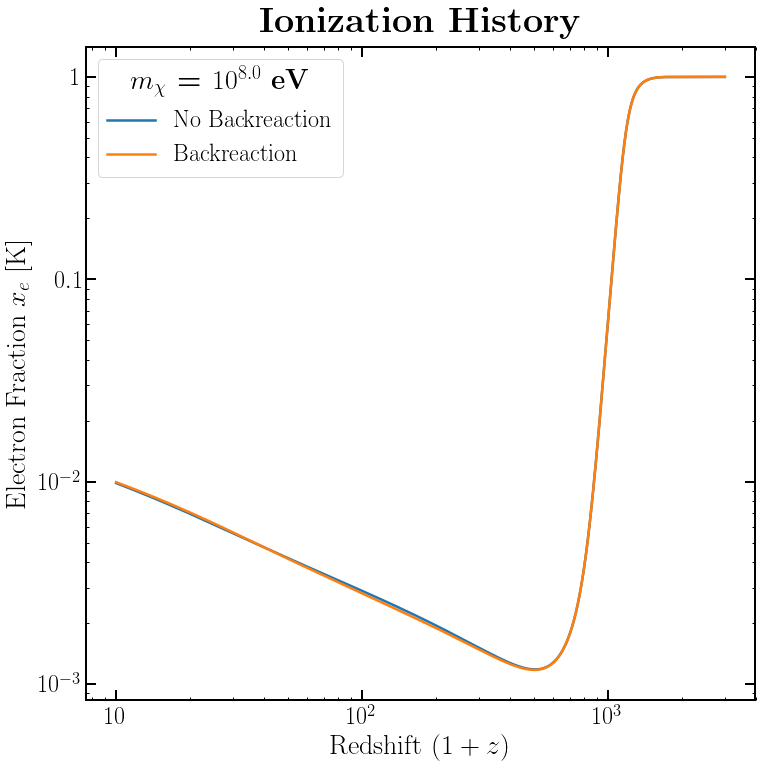

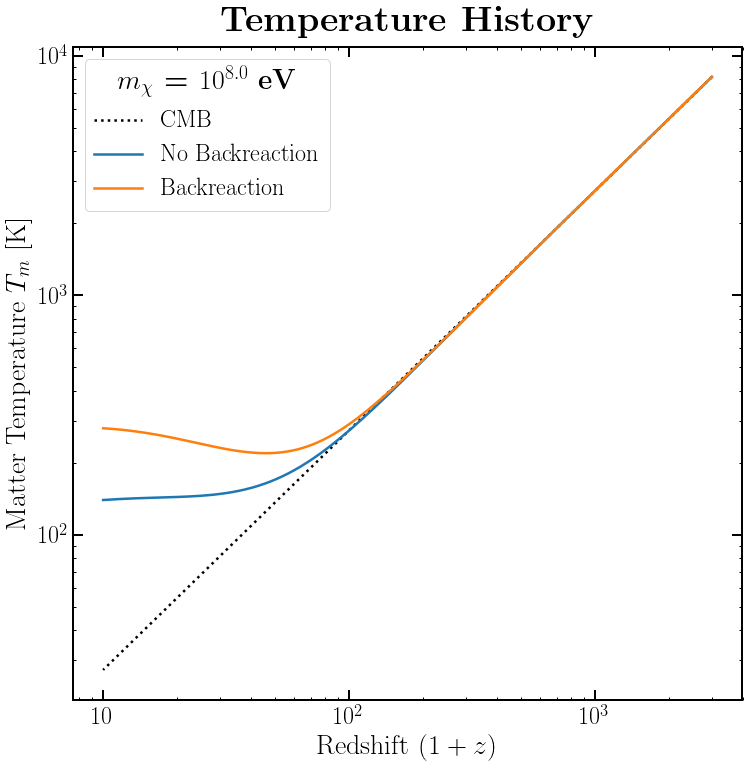

In [79]:
plt.figure()
plt_xe_std, = plt.plot(a[3].rs, a[0], label='No Backreaction')
plt_xe_backReact, = plt.plot(b[3].rs, b[0], label='Backreaction')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Electron Fraction $x_e$ [K]')
leg = plt.legend(handles=[plt_xe_std, plt_xe_backReact],
                 title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.figure()
plt_TCMB, = plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:', label='CMB')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='No Backreaction')
plt_Tm_backReact, = plt.plot(b[3].rs, b[1]/phys.kB, label='Backreaction')

# plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
leg2 = plt.legend(handles=[plt_TCMB, plt_Tm_std, plt_Tm_backReact],
                  title=r'$m_\chi$\bf{ = $10^{'+str(np.log10(mDM))+'}$ eV}',
                  loc=2
                 )
plt.setp(leg2.get_title(),fontsize=28)

# Comparison to old results

# Import Standard Solution

In [76]:
std_soln = pickle.load(open('/Users/gridgway/Dropbox (MIT)/21cm_pwave/TLA_code/examples/old_notebooks/standard_soln.p','rb'))
std_soln_rs = std_soln[0]
std_soln_T = std_soln[1]
std_soln_xe = std_soln[2]

# Import $f(z)$

In [61]:
user = 'gridgway'
greg = ''

#---------- Decay ----------#
fz_elec_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}


#---------- s-wave ----------#
fz_elec_swave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_elec_swave[0:70, 1]
log10eng = fz_elec_swave[0:2800:70, 0] 

log10f_elec_swave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_swave[11200:14000,2], (40,70))) 
}

fz_phot_swave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_phot_swave[0:70, 1]
log10eng = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70)))
}

#---------- p-wave ----------#
fz_elec_pwave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_elec_pwave[0:70, 1]
log10eng = fz_elec_pwave[0:2800:70, 0] 

log10f_elec_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_pwave[11200:14000,2], (40,70))) 
}

fz_phot_pwave = np.loadtxt('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/TLA_code/fz_photon_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_phot_pwave[0:70, 1]
log10eng = fz_phot_pwave[0:2800:70, 0] 

log10f_phot_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_pwave[11200:14000,2], (40,70)))
}


# Heating Processes

In [62]:
def compton_cooling_rate(xe, T_matter, rs):
    """Returns the Compton cooling rate. 

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    T_matter : float
        The matter temperature in eV. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Compton cooling rate in eV/s. 
    """
    return (
        xe / (1 + xe + phys.nHe/phys.nH) * (phys.TCMB(rs) - T_matter)
        * 32 * phys.thomson_xsec * phys.stefboltz
        * phys.TCMB(rs)**4 / (3 * phys.me)
    )



# Ionization Processes

In [63]:
def alpha_recomb(T_matter):
    """Case-B recombination coefficient. 

    Parameters
    ----------
    T_matter : float
        The matter temperature. 

    Returns
    -------
    float
        Case-B recombination coefficient in cm^3/s. 
    """ 
    
    # Fudge factor recommended in 1011.3758
    fudge_fac = 1.126

    return (
        fudge_fac * 1e-13 * 4.309 * (1.16405*T_matter)**(-0.6166)
        / (1 + 0.6703 * (1.16405*T_matter)**0.5300)
    )

def beta_ion(T_rad):
    """Case-B photoionization coefficient. 

    Parameters
    ----------
    T_rad : float
        The radiation temperature. 

    Returns
    -------
    float
        Case-B photoionization coefficient in s^-1. 

    """
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    return (
        (1/de_broglie_wavelength)**3/4 
        * np.exp(-phys.rydberg/4/T_rad) * alpha_recomb(T_rad)
    )

def peebles_C(xe, rs):
    """Returns the Peebles C coefficient. 

    This is the ratio of the total rate for transitions from n = 2 to the ground state to the total rate of all transitions, including ionization.

    Parameters
    ----------
    xe : float
        The ionization fraction ne/nH. 
    Tm : float
        The matter temperature. 
    rs : float
        The redshift in 1+z. 

    Returns
    -------
    float
        The Peebles C factor. 
    """

    # Net rate for 2p to 1s transition, times (1-xe). 
    rate_2p1s = (
        8 * np.pi * phys.hubble(rs)
        /(3*(phys.nH*rs**3 * (phys.c/phys.lya_freq)**3))
    )

    # Net rate for 2s to 1s transition, times (1-xe).
    rate_2s1s = phys.width_2s1s * (1-xe)

    # Net rate for ionization, times (1-xe).
    rate_ion = beta_ion(phys.TCMB(rs)) * (1-xe)

    # Rate is averaged over 3/4 of excited state being in 2p, 1/4 in 2s. 
    return (
        (3*rate_2p1s/4 + rate_2s1s/4)
        /(3*rate_2p1s/4 + rate_2s1s/4 + rate_ion)
    )

# TLA Differential Equation

In [70]:
import darkhistory.physics as phys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad

def get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, 
    dm_injection_rate, dm_injection_param, rs_vec
):
    """Returns the ionization and thermal history of the IGM. 

    Parameters
    ----------
    init_cond : array
        Array containing [initial temperature, initial xe]
    fz_H_ion : function
        f(xe, rs) for hydrogen ionization. 
    fz_H_exc : function
        f(xe, rs) for hydrogen Lyman-alpha excitation. 
    f_heating : function
        f(xe, rs) for heating. 
    dm_injection_rate : function
        Injection rate of DM as a function of redshift, and one parameter (lifetime or cross section). 
    dm_injection_param : float
        The injection parameter (lifetime or cross section).
    rs_vec : ndarray
        Abscissa for the solution. 

    Returns
    -------
    list of ndarray
        [temperature solution (in eV), xe solution]. 

    Note
    ----
    The actual differential equation that we solve is expressed in terms of y = arctanh(2*(xe - 0.5)). 

    """

    def tla_diff_eq(var, rs):
        # Returns an array of values for [dT/dz, dy/dz].
        # var is the [temperature, xe] inputs. 

        def xe(y):
            return 0.5 + 0.5*np.tanh(y)

        def dT_dz(T_matter, y, rs):
            #print(y)
            return (
                2*T_matter/rs - phys.dtdz(rs) * (
                    compton_cooling_rate(xe(y), T_matter, rs)
                    + (
                        1/(1 + xe(y) + phys.nHe/phys.nH)
                        * 2/(3 * phys.nH * rs**3)
                        * f_heating(rs, xe(y))
                        * dm_injection_rate(rs, dm_injection_param)
                    )
                )
            )

        def dy_dz(T_matter, y, rs):
            # Stops any change in y once it exceeds y = 4, or xe = 0.999665
            #print(rs, y)
            if y > 4 and rs < 100:
                return 0
            #if math.isinf(np.cosh(y)) or math.isnan(np.cosh(y)):
            #    print("y, xe, dtdz: ", y, " ", xe(y), " ", phys.dtdz(rs))
            return (
                2 * np.cosh(y)**2 * phys.dtdz(rs) * (
                    peebles_C(xe(y), rs) * (
                        alpha_recomb(T_matter) * xe(y)**2 * phys.nH * rs**3
                        - (
                            beta_ion(phys.TCMB(rs)) * (1 - xe(y))
                            * np.exp(-phys.lya_eng/T_matter)
                        )
                    )
                    - (
                        f_H_ion(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param)
                        / (phys.rydberg * phys.nH * rs**3)
                    )
                    - (1 - peebles_C(xe(y), rs)) * (
                        f_H_exc(rs, xe(y)) * dm_injection_rate(rs, dm_injection_param) 
                        / (phys.lya_eng * phys.nH * rs**3)
                    )
                )
            )

        T_matter, y = var[0], var[1]
        return [dT_dz(T_matter, y, rs), dy_dz(T_matter, y, rs)]

    mod_init_cond = np.array(init_cond)
    
    if mod_init_cond[1] == 1:
        mod_init_cond[1] = 1 - 1e-12
    
    mod_init_cond[1] = np.arctanh(2*(mod_init_cond[1] - 0.5))

    soln = odeint(tla_diff_eq, mod_init_cond, rs_vec)

    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])

    return soln

# TLA Full Solution

In [71]:
logmDM = 8
mDM = 10**logmDM
if np.log10(mDM) < 6:
    units = 'keV'
    mass = str(mDM/10**3)
elif np.log10(mDM) < 9:
    units = 'MeV'
    mass = str(mDM/10**6)
else:
    units = 'GeV'
    mass = str(int(mDM/10**9))

inj_type = 'decay'
#inj_param = 7e-29
prefactor = 1
exponent = -24
inj_param = prefactor * 10**exponent
#[-30.5, -30, -28.5, -27, -25.5]

# Set all of the fractions and DM injection functions.

def f_0(rs, xe):
    return np.zeros_like(rs)

def f_H_ion(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_ion'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_ion'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_ion'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_H_exc(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['H_exc'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['H_exc'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['H_exc'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def f_heating(rs, xe):
    if inj_type == 'decay':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_decay['heating'])
    elif inj_type == 'swave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_swave['heating'])
    elif inj_type == 'pwave':
        interp_func = interp2d(log10eng, log10rs, log10f_phot_pwave['heating'])
    return 10**interp_func(np.log10(mDM - phys.me), np.log10(rs))[0]

def dm_injection_rate(rs, param):
    if inj_type == 'decay':
        return phys.rho_DM*rs**3/param
    elif inj_type == 'swave':
        return phys.rho_DM**2*rs**6*param/mDM
    elif inj_type == 'pwave':
        sigma_1D_B = 1e-11*phys.c*(1/100)**0.5
        return phys.rho_DM**2*rs**8*param/mDM*(sigma_1D_B/1e7)**2

rs_start = 3000
init_cond = [phys.TCMB(rs_start), 1]
rs_vec = np.flipud(1 + np.arange(0,rs_start-0.5,0.5))


inj_type = 'decay'
inj_param = 1e24

soln = get_history(init_cond, f_0, f_0, f_0, dm_injection_rate, inj_param, rs_vec)
soln_dec = get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, inj_param, rs_vec)

[10, 2000.0, 1, 20000.0]

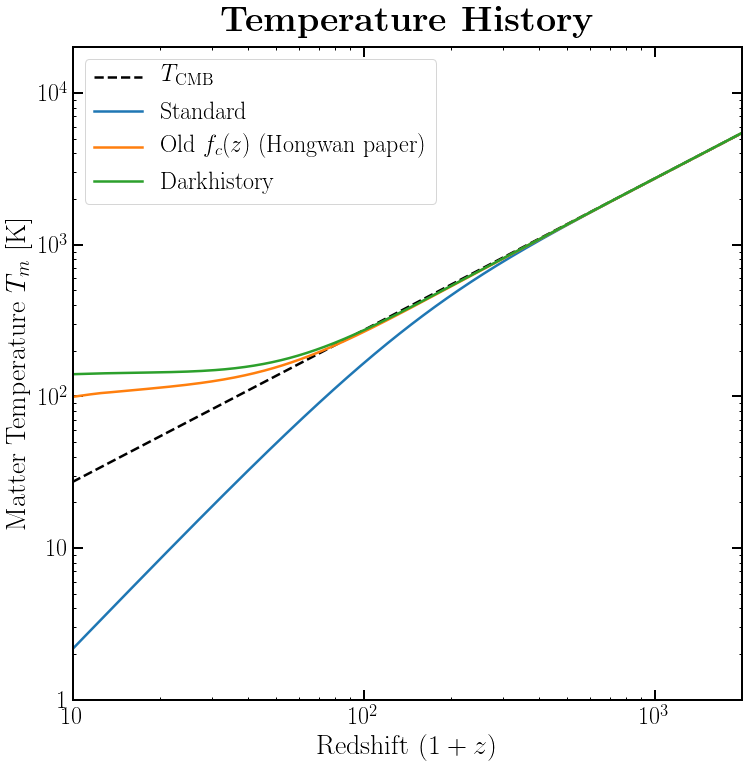

In [86]:
matplotlib.rcParams['figure.figsize'] = [12,12]
plt.figure()

ax = plt.gca()

T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label=r'$T_\mathrm{CMB}$')
T_IGM_std, = plt.plot(std_soln_rs, std_soln_T, label='Standard')
T_IGM_dec, = plt.plot(rs_vec, soln_dec[:,0]/phys.kB, alpha=1.0, label=r'Old $f_c(z)$ (Hongwan paper)')
plt_Tm_std, = plt.plot(a[3].rs, a[1]/phys.kB, label='Darkhistory')

ax.set_xscale('log')
ax.set_yscale('log')

leg = plt.legend(handles=[T_CMB, T_IGM_std, T_IGM_dec, plt_Tm_std], 
                 #title=r'$m_\chi$\bf{ = '+mass+' '+units+' }',#$(1+z)_\mathrm{td} = 500$',
                 loc=2
                )
plt.setp(leg.get_title(),fontsize=28)

plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Matter Temperature $T_m$ [K]')
plt.axis([10, 2e3, 1, 2e4])

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/21cm_pwave/plots/T_standard_dec_swave_pwave_constraint.pdf')